### Exploratory data analyis of dividend capture strategy
for the S&P 500, starting in 2010

by Flor Lozano-Byrne

In [36]:
import pandas as pd
import dill
from datetime import datetime, timedelta,date
from collections import defaultdict

In [78]:
import sys
import warnings

if not sys.warnoptions:
    warnings.simplefilter('ignore')

import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
from tqdm import tqdm
sns.set()
torch.manual_seed(1234)

In [38]:
d = dill.load(open('codebase/data/d_all_EOD.pkd', 'rb'))
for ticker in d.keys():
    d[ticker] = d[ticker].reset_index(drop = True)
    

### Find stocks that currently pay dividends

In [39]:
divs = []
for ticker in d.keys():
    df = d[ticker].copy(deep=True)
    df = df[df.date > datetime(2022,11,1)]
    if [x for x in df['divCash'].values if x>0]:
        divs.append(ticker)
print(len(divs))
divs

397


['BALL',
 'BBWI',
 'TECH',
 'BX',
 'BRO',
 'BG',
 'CPT',
 'COR',
 'CTRA',
 'ELV',
 'EQT',
 'EG',
 'FDS',
 'GEN',
 'HUBB',
 'INVH',
 'KDP',
 'MPWR',
 'NDSN',
 'NXPI',
 'PARA',
 'RVTY',
 'STLD',
 'TRGP',
 'VTRS',
 'VICI',
 'WTW',
 'SPY',
 'ABT',
 'ABBV',
 'ACN',
 'AES',
 'AFL',
 'A',
 'APD',
 'ALB',
 'ARE',
 'ALLE',
 'LNT',
 'ALL',
 'MO',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'AON',
 'AOS',
 'APA',
 'AAPL',
 'AMAT',
 'ADM',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADP',
 'AVB',
 'AVY',
 'BKR',
 'BAC',
 'BK',
 'BAX',
 'BDX',
 'BBY',
 'BLK',
 'BWA',
 'BXP',
 'BMY',
 'AVGO',
 'BR',
 'CHRW',
 'CPB',
 'COF',
 'CAH',
 'CARR',
 'CAT',
 'CBOE',
 'CDW',
 'CE',
 'CNP',
 'CF',
 'SCHW',
 'CVX',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'CL',
 'CMCSA',
 'CMA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 'COO',
 'GLW',
 'CTVA',
 'COST',
 'CCI',
 'CSX',
 'CMI',
 'CVS',
 'DHI',
 'DHR',
 'DRI',
 'DE',
 '

### Case 1: Maximum Gain
Total gains in the last 13 years, buying at the low the day before the ex-dividend and selling at the high the day after the ex-dividend

In [40]:
def record_gains(startdate = datetime(2010,1,1), max_gain = True):
    dicts = []
    for ticker in divs:
        gain_ct = 0
        loss_ct = 0
        gain_tot = 0
        loss_tot = 0
        net = 0
        df = d[ticker]
        df = df[df.date > startdate]
        df1 = df[df['divCash']>0]
        for index, row in df1.iterrows():
            df2 = df.loc[index - 1:index + 1]
            if len(df2) != 3:
                print('incorrect dataframe length: {} for ticker {}'.format(len(df2),ticker))
                continue
            if max_gain:
                change = df2.high.values[2] - df2.low.values[0]
            else:
                highs = df2.high.values
                lows = df2.low.values
                change = (highs[2] - highs[0] - lows[2] + lows[0])/2
            div = df2.divCash.values[1]
            gain = change + div
            if gain > 0:
                gain_ct +=1
                gain_tot += gain
            else:
                loss_ct +=1
                loss_tot += gain
            net += gain
        dicts.append({'ticker':ticker
                  , 'gain_ct': gain_ct
                 , 'gain_tot': gain_tot
                 , 'loss_ct': loss_ct
                 , 'loss_tot': loss_tot
                 , 'net': net})
    return pd.DataFrame(dicts).sort_values('net').reset_index(drop=True)
max_gains = record_gains()
max_gains

incorrect dataframe length: 2 for ticker AMP
incorrect dataframe length: 2 for ticker BKR
incorrect dataframe length: 2 for ticker BKR
incorrect dataframe length: 2 for ticker C
incorrect dataframe length: 2 for ticker CMCSA
incorrect dataframe length: 2 for ticker ETN
incorrect dataframe length: 2 for ticker GL
incorrect dataframe length: 2 for ticker JPM
incorrect dataframe length: 2 for ticker KHC


,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
0,KVUE,1,0.26000,0,0.0000,0.26000
1,VTRS,8,1.70250,2,-0.4750,1.22750
2,LH,4,6.25000,2,-4.2500,2.00000
3,GEHC,3,2.66330,0,0.0000,2.66330
4,T,8,3.65440,4,-0.4885,3.16590
...,...,...,...,...,...,...
392,MA,49,355.40710,7,-5.8950,349.51210
393,GWW,50,408.27600,5,-19.1740,389.10200
394,EQIX,34,424.98684,3,-29.1811,395.80574
395,LRCX,33,469.69790,5,-32.8225,436.87540


In [41]:
max_gains[max_gains.gain_ct<max_gains.loss_ct]


,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net


<Axes: >

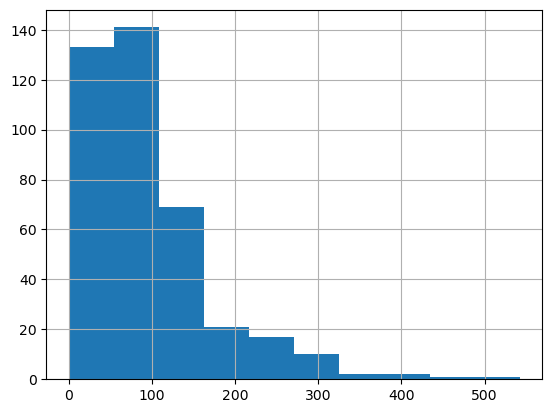

In [42]:
max_gains.net.hist()

### Case 2: Maximum Gain in the last year

In [43]:
STARTDATE = datetime(2022,10,26)

In [44]:
latest_max_gains = record_gains(startdate = STARTDATE)
latest_max_gains

incorrect dataframe length: 2 for ticker AMP
incorrect dataframe length: 2 for ticker BKR
incorrect dataframe length: 2 for ticker CARR
incorrect dataframe length: 2 for ticker C
incorrect dataframe length: 2 for ticker COST
incorrect dataframe length: 2 for ticker ETN


,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
0,UHS,3,9.8150,1,-12.3500,-2.5350
1,ES,1,0.1350,3,-1.6900,-1.5550
2,WYNN,1,0.5800,1,-1.5400,-0.9600
3,DVN,2,0.5182,2,-1.0751,-0.5569
4,FRT,2,3.1600,2,-3.6850,-0.5250
...,...,...,...,...,...,...
392,KLAC,4,68.8300,0,0.0000,68.8300
393,POOL,4,73.8100,0,0.0000,73.8100
394,INTU,4,90.0600,0,0.0000,90.0600
395,MPWR,4,99.7750,0,0.0000,99.7750


In [45]:
### Companies that lost using this strategy in the last year
latest_max_gains[latest_max_gains.net < 0]

,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
0,UHS,3,9.8150,1,-12.3500,-2.5350
1,ES,1,0.1350,3,-1.6900,-1.5550
2,WYNN,1,0.5800,1,-1.5400,-0.9600
3,DVN,2,0.5182,2,-1.0751,-0.5569
4,FRT,2,3.1600,2,-3.6850,-0.5250


In [46]:
### How the losing companies last years did over the last 13 years
max_gains[max_gains.ticker.isin(latest_max_gains[latest_max_gains.net < 0].ticker.values)]

,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
134,DVN,45,64.6984,12,-9.14010,55.55830
146,ES,48,63.2445,10,-4.62875,58.61575
254,FRT,47,121.9724,9,-20.53510,101.43730
319,UHS,49,149.3199,4,-14.40000,134.91990
321,WYNN,35,152.0353,8,-14.70950,137.32580


<Axes: >

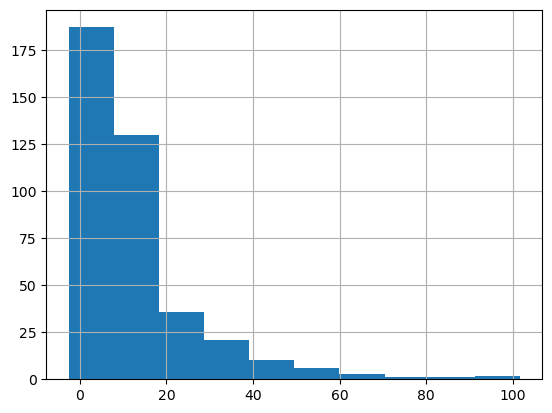

In [47]:
### Distributiion of net gains
latest_max_gains.net.hist()

### Case 3: Average Gain
Total gains in the last 13 years, assuming buys at the midpoint between high and low the day before the ex-dividend and selling at the midpoint between high and low the day after the ex-dividend

In [48]:
avg_gains = record_gains(max_gain = False)
avg_gains

incorrect dataframe length: 2 for ticker AMP
incorrect dataframe length: 2 for ticker BKR
incorrect dataframe length: 2 for ticker BKR
incorrect dataframe length: 2 for ticker C
incorrect dataframe length: 2 for ticker CMCSA
incorrect dataframe length: 2 for ticker ETN
incorrect dataframe length: 2 for ticker GL
incorrect dataframe length: 2 for ticker JPM
incorrect dataframe length: 2 for ticker KHC


,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
0,MPWR,18,9.67330,21,-25.41290,-15.73960
1,POOL,37,25.87620,18,-41.12025,-15.24405
2,NVDA,6,5.60345,6,-16.37205,-10.76860
3,GE,6,1.68090,6,-1.98310,-0.30220
4,CEG,4,1.35350,3,-1.56950,-0.21600
...,...,...,...,...,...,...
392,PSA,55,101.29950,1,-2.69750,98.60200
393,EQIX,32,112.34044,5,-9.77780,102.56264
394,KDP,50,122.21950,5,-0.72750,121.49200
395,LMT,55,123.71545,0,0.00000,123.71545


In [49]:
avg_gains[avg_gains.net < 0]

,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
0,MPWR,18,9.67330,21,-25.41290,-15.73960
1,POOL,37,25.87620,18,-41.12025,-15.24405
2,NVDA,6,5.60345,6,-16.37205,-10.76860
3,GE,6,1.68090,6,-1.98310,-0.30220
4,CEG,4,1.35350,3,-1.56950,-0.21600
5,PAYC,1,0.95500,1,-1.15510,-0.20010


In [50]:
max_gains[max_gains.ticker.isin(avg_gains[avg_gains.net < 0].ticker.values)]

,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
30,PAYC,2,17.2298,0,0.0000,17.2298
32,CEG,6,19.1490,1,-0.4885,18.6605
61,GE,11,29.1306,1,-0.6400,28.4906
312,NVDA,11,145.3096,1,-15.1200,130.1896
382,MPWR,37,279.4469,2,-1.0400,278.4069
390,POOL,52,328.1517,3,-3.9550,324.1967


<Axes: >

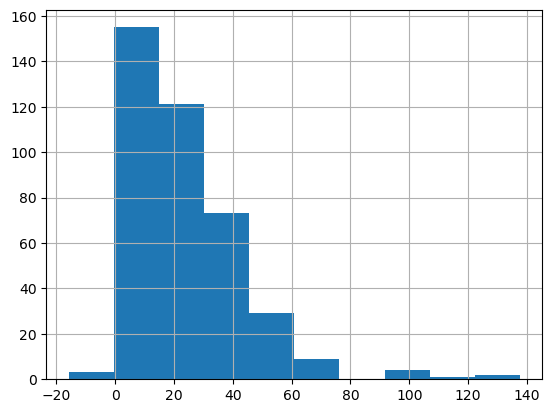

In [51]:
avg_gains.net.hist()

### Case 4: Average gain in the last year

In [52]:
latest_avg_gains = record_gains(startdate = STARTDATE, max_gain=False)
latest_avg_gains

incorrect dataframe length: 2 for ticker AMP
incorrect dataframe length: 2 for ticker BKR
incorrect dataframe length: 2 for ticker CARR
incorrect dataframe length: 2 for ticker C
incorrect dataframe length: 2 for ticker COST
incorrect dataframe length: 2 for ticker ETN


,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
0,AON,2,1.670000,3,-16.90440,-15.234400
1,CMA,1,0.042500,3,-7.97000,-7.927500
2,MPWR,0,0.000000,4,-5.77750,-5.777500
3,ALB,1,1.249950,3,-6.50360,-5.253650
4,PH,1,1.035000,3,-3.80640,-2.771400
...,...,...,...,...,...,...
392,PXD,4,19.340500,0,0.00000,19.340500
393,NDSN,3,21.417600,1,-1.04995,20.367650
394,BLK,4,24.828450,0,0.00000,24.828450
395,AVGO,4,26.530050,0,0.00000,26.530050


In [53]:
latest_avg_gains[latest_avg_gains.net < 0]

,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
0,AON,2,1.670000,3,-16.904400,-15.23440
1,CMA,1,0.042500,3,-7.970000,-7.92750
2,MPWR,0,0.000000,4,-5.777500,-5.77750
3,ALB,1,1.249950,3,-6.503600,-5.25365
4,PH,1,1.035000,3,-3.806400,-2.77140
5,COO,0,0.000000,2,-2.471250,-2.47125
6,SPGI,1,0.060000,3,-2.235000,-2.17500
7,CF,1,1.005000,3,-2.622500,-1.61750
8,AMP,2,1.700000,2,-3.270000,-1.57000
9,EFX,2,0.802500,2,-2.297500,-1.49500


In [54]:
max_gains[max_gains.ticker.isin(latest_avg_gains[latest_avg_gains.net < 0].ticker.values)]

,ticker,gain_ct,gain_tot,loss_ct,loss_tot,net
30,PAYC,2,17.229800,0,0.000000,17.229800
33,APH,11,19.885000,2,-0.605000,19.280000
52,MGM,20,27.651600,4,-2.150000,25.501600
61,GE,11,29.130600,1,-0.640000,28.490600
85,HRL,53,40.905000,3,-0.882500,40.022500
87,DAL,28,40.513500,1,-0.287500,40.226000
128,XRAY,49,55.339900,6,-1.670000,53.669900
164,XYL,40,71.770000,8,-6.060600,65.709400
167,STLD,51,68.574700,4,-1.465200,67.109500
188,PGR,31,74.625600,1,-0.260000,74.365600


<Axes: >

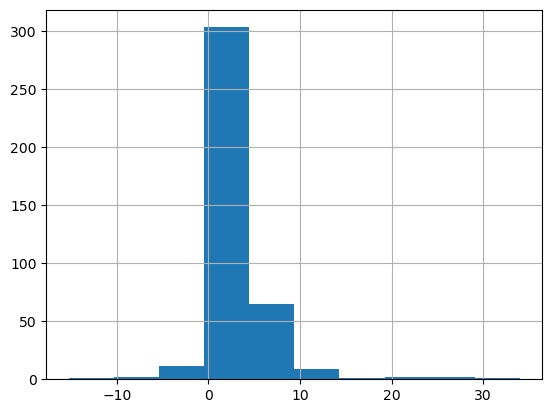

In [55]:
latest_avg_gains.net.hist()

### Portfolio Analysis
Comparing holding SPY ETF vs switching to capture dividends for 3 days and switching back to SPY

In [56]:
d['SPY'][d['SPY'].date > STARTDATE]

,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
3227,2022-10-27,379.98,385.000,379.3300,383.07,81971756,374.031927,378.973346,373.392102,377.073558,81971756,0.0,1.0
3228,2022-10-28,389.02,389.520,379.6800,379.87,100301958,382.930418,383.422592,373.736623,373.923649,100301958,0.0,1.0
3229,2022-10-31,386.21,388.400,385.2600,386.44,96631258,380.164405,382.320124,379.229276,380.390805,96631258,0.0,1.0
3230,2022-11-01,384.52,390.390,383.2900,390.14,85407598,378.500860,384.278973,377.290114,384.032886,85407598,0.0,1.0
3231,2022-11-02,374.87,388.630,374.7600,383.90,126990356,369.001917,382.546523,368.893639,377.890565,126990356,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3479,2023-10-30,415.59,416.680,412.2200,413.56,86562675,415.590000,416.680000,412.220000,413.560000,86562675,0.0,1.0
3480,2023-10-31,418.20,418.530,414.2100,416.18,79665150,418.200000,418.530000,414.210000,416.180000,79665150,0.0,1.0
3481,2023-11-01,422.66,423.500,418.6499,419.20,98068115,422.660000,423.500000,418.649900,419.200000,98068115,0.0,1.0
3482,2023-11-02,430.76,430.915,426.5600,426.58,94938909,430.760000,430.915000,426.560000,426.580000,94938909,0.0,1.0


In [57]:
### Holding SPY, buying at the close, final value at the close
def calc_spy():
    n_shares = 100
    df = d['SPY'][d['SPY'].date > STARTDATE]
    entry = n_shares * df.iloc[0].adjClose
    print('Original Investment: {}'.format(entry))
    exit = n_shares * df.iloc[-1].adjClose
    profit = exit - entry
    print('Profit: {}%'.format(profit/entry*100))
    return entry
orig_invest = calc_spy()

Original Investment: 37403.19273072
Profit: 16.21735158533145%


In [58]:
def create_dc_sched(startdate, max_gain):
    dicts = []
    df_divs = pd.DataFrame()
    for ticker in divs:
        gain_tot = 0
        loss_tot = 0
        net = 0
        df = d[ticker]
        df = df[df.date > startdate]
        df1 = df[df['divCash']>0]
        df1['ticker'] = ticker
        df_divs =df_divs.append(df1)
    return df_divs.sort_values('date')
        
df_divs = create_dc_sched(STARTDATE, True)

/var/folders/fc/t0bwqwx93fvg5l3tyccc608c0000gn/T/ipykernel_25212/643056166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ticker'] = ticker
/var/folders/fc/t0bwqwx93fvg5l3tyccc608c0000gn/T/ipykernel_25212/643056166.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_divs =df_divs.append(df1)
/var/folders/fc/t0bwqwx93fvg5l3tyccc608c0000gn/T/ipykernel_25212/643056166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

/var/folders/fc/t0bwqwx93fvg5l3tyccc608c0000gn/T/ipykernel_25212/643056166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1['ticker'] = ticker
/var/folders/fc/t0bwqwx93fvg5l3tyccc608c0000gn/T/ipykernel_25212/643056166.py:12: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_divs =df_divs.append(df1)
/var/folders/fc/t0bwqwx93fvg5l3tyccc608c0000gn/T/ipykernel_25212/643056166.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

In [59]:
df_divs.to_csv('dividends.csv')

### Run trading simulations of past year trades

In [60]:
df_divs = pd.read_csv('dividends.csv')

In [61]:
### Too many each day, need to choose
df_divs

,Unnamed: 0,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor,ticker
0,658,2022-10-27,37.88,38.5900,37.530,38.05,7529894,37.252137,37.950369,36.907938,37.419319,7529894,0.150,1.0,CARR
1,3227,2022-10-27,496.54,503.0100,494.140,499.81,1576567,492.807491,499.228856,490.425532,496.052910,1576567,0.900,1.0,COST
2,3228,2022-10-28,54.38,54.4850,51.920,51.96,1063284,53.179051,53.281732,50.773379,50.812495,1063284,0.300,1.0,AOS
3,3228,2022-10-28,82.22,82.2950,79.510,80.27,7816061,79.167709,79.239925,76.558314,77.290100,7816061,0.775,1.0,MS
4,3228,2022-10-28,96.10,96.3750,93.660,94.49,858656,93.809202,94.077647,91.427366,92.237581,858656,0.700,1.0,CE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1611,3482,2023-11-02,555.97,559.5100,552.010,556.50,2100573,555.970000,559.510000,552.010000,556.500000,2100573,1.020,1.0,COST
1612,1595,2023-11-03,35.19,35.5400,34.945,35.53,5519138,35.190000,35.540000,34.945000,35.530000,5519138,0.200,1.0,BKR
1613,3483,2023-11-03,335.74,340.2600,334.250,334.29,708067,335.740000,340.260000,334.250000,334.290000,708067,1.350,1.0,AMP
1614,3483,2023-11-03,214.79,219.5399,214.715,218.71,1852921,214.790000,219.539900,214.715000,218.710000,1852921,0.860,1.0,ETN


#### 1. Using ideal entry and exit prices (high -low)

In [63]:
### For each day, choose the ticker with the highest historical gains
def trades(start_amount, max_gain=True):
    curr_val = start_amount
    avail_amts = [curr_val / 3] * 3
    total = 0
    curr_avail_index = 0
    d_trades = defaultdict(list)
    d_trade_dates = {}
    for date in df_divs.date.unique():
        if curr_avail_index > 2:
            curr_avail_index = 0
        df1 = df_divs[df_divs.date == date]
        tickers = df1.ticker.values
        d_indexes ={}
        for ticker in tickers:
            d_indexes[ticker] = max_gains[max_gains.ticker == ticker].index[0]    
        selected_ticker = sorted([x for x in d_indexes.items()], key=lambda x:x[1], reverse=True)[0][0]
        df2 = d[selected_ticker]
        idx = df2[df2.date == date].index[0]
        df2 = df2.loc[idx - 1:idx + 1]
        if len(df2) == 3:
            d_trades[selected_ticker].append(date)
            d_trade_dates[date] = selected_ticker
            if max_gain:
                entry_price = df2.low.values[0]
                gain = df2.high.values[2] - entry_price + df2.divCash.values[1]
            else:
                highs = df2.high.values
                lows = df2.low.values
                entry_price = (highs[0] + lows[0]) / 2
                gain = (highs[2] + lows[2]) / 2 - entry_price + df2.divCash.values[1]
            n_shares = avail_amts[curr_avail_index] // entry_price
            gain *= n_shares
            avail_amts[curr_avail_index] += gain
            total += gain
            #print('Number of shares: {}, Gain {}'.format(n_shares,gain))
            #print(avail_amts, sum(avail_amts))
            curr_avail_index += 1
    print('Total gains: {}'.format(total))
    print('Percent return: {}%'.format(total/start_amount * 100))
    if max_gain:
        dill.dump(d_trades,open('codebase/data/d_trades.pkd','wb'))
        dill.dump(d_trade_dates,open('codebase/data/d_trade_dates.pkd','wb'))
    return d_trades

d_trades = trades(orig_invest)

Total gains: 189254.33683600012
Percent return: 505.98444415832364%


In [64]:
orig_invest

37403.19273072

In [65]:
trades(orig_invest, max_gain = False)

Total gains: 3071.7541369999844
Percent return: 8.212545274182142%


defaultdict(list,
            {'COST': ['2022-10-27',
              '2023-02-02',
              '2023-05-04',
              '2023-08-24',
              '2023-11-02'],
             'CE': ['2022-10-28', '2023-07-28', '2023-10-27'],
             'AON': ['2022-10-31',
              '2023-01-31',
              '2023-04-28',
              '2023-07-31',
              '2023-10-31'],
             'MKTX': ['2022-11-01', '2023-02-07', '2023-05-09', '2023-08-01'],
             'CAG': ['2022-11-02', '2023-11-01'],
             'NSC': ['2022-11-03', '2023-08-03'],
             'AMP': ['2022-11-04', '2023-02-09', '2023-08-04'],
             'AWK': ['2022-11-07', '2023-02-06', '2023-05-08', '2023-08-07'],
             'WST': ['2022-11-08', '2023-01-24', '2023-04-25', '2023-07-25'],
             'POOL': ['2022-11-09', '2023-05-16', '2023-08-09'],
             'GWW': ['2022-11-10', '2023-02-10', '2023-05-05', '2023-08-11'],
             'TFX': ['2022-11-14', '2023-03-02', '2023-08-14'],
             'EQ

In [66]:
d_trade_dates = dill.load(open('codebase/data/d_trade_dates.pkd','rb'))
d_trade_dates

{'2022-10-27': 'COST',
 '2022-10-28': 'CE',
 '2022-10-31': 'AON',
 '2022-11-01': 'MKTX',
 '2022-11-02': 'CAG',
 '2022-11-03': 'NSC',
 '2022-11-04': 'AMP',
 '2022-11-07': 'AWK',
 '2022-11-08': 'WST',
 '2022-11-09': 'POOL',
 '2022-11-10': 'GWW',
 '2022-11-14': 'TFX',
 '2022-11-15': 'EQIX',
 '2022-11-16': 'AMGN',
 '2022-11-17': 'WHR',
 '2022-11-18': 'TSCO',
 '2022-11-21': 'SWKS',
 '2022-11-22': 'EG',
 '2022-11-23': 'HII',
 '2022-11-25': 'NOC',
 '2022-11-28': 'KEY',
 '2022-11-29': 'FDS',
 '2022-11-30': 'GS',
 '2022-12-01': 'TT',
 '2022-12-02': 'UNH',
 '2022-12-05': 'CI',
 '2022-12-06': 'BLK',
 '2022-12-07': 'NEM',
 '2022-12-08': 'CME',
 '2022-12-09': 'FDX',
 '2022-12-12': 'BBY',
 '2022-12-13': 'LRCX',
 '2022-12-14': 'TMO',
 '2022-12-15': 'CB',
 '2022-12-16': 'UNP',
 '2022-12-19': 'AVGO',
 '2022-12-20': 'STX',
 '2022-12-21': 'PM',
 '2022-12-23': 'COP',
 '2022-12-27': 'CME',
 '2022-12-28': 'XEL',
 '2022-12-29': 'HUM',
 '2022-12-30': 'ESS',
 '2023-01-03': 'CMCSA',
 '2023-01-04': 'CPB',
 '2023

### 2. Using ARIMA predicted prices

In [67]:
N_PRIOR_DAYS = 251

In [68]:
### create arima datasets

def adjust_splits(df):
    df = df.reset_index(drop = True)
    splits = [(datetime.strptime(str(x[0])[:10],'%Y-%m-%d'),x[1]) for x in df[df.splitFactor != 1][['date','splitFactor']].to_records(index=False)]
    df = df[['date','close','high','low']].set_index('date')
    for date, factor in splits:
        df.loc[df.index < date] = df.loc[df.index < date] / factor
    return df

d_dfs = defaultdict(dict)
for ticker, dates in d_trades.items():
    df = adjust_splits(d[ticker])
    dates = [datetime.strptime(str(x),'%Y-%m-%d') for x in dates]
    for date in dates:
        df1 = df.loc[df.index <= date][-N_PRIOR_DAYS:]
        if len(df1) >= N_PRIOR_DAYS:
            d_dfs[ticker][date] = df1
dill.dump(d_dfs,open('codebase/data/d_dfs.pkd','wb'))

In [77]:
ticker, dates = list(d_dfs.items())[0]
date, df = list(dates.items())[0]
print(df['low'].to_numpy())
            

[486.66   487.2    492.72   495.75   506.0101 508.63   500.2    504.06
 503.765  504.04   513.23   518.01   517.41   524.505  522.4944 528.01
 532.32   533.77   543.32   544.31   542.41   535.89   529.4    514.04
 524.77   527.5701 534.71   525.55   523.8    534.61   547.98   537.5676
 545.53   549.45   540.98   538.03   536.08   539.8    547.49   551.44
 560.7    563.5    562.37   559.03   555.51   561.79   549.77   543.55
 534.24   508.5    510.29   522.01   515.23   501.86   486.86   487.1
 481.84   481.32   469.01   472.37   478.77   480.31   475.901  490.63
 496.94   510.34   514.21   510.8034 514.23   510.5    525.68   514.7498
 507.38   501.44   510.7632 501.71   507.03   510.3305 498.16   494.775
 482.98   505.2461 511.3    519.19   519.77   529.54   511.78   523.4222
 522.41   515.71   518.14   526.43   523.54   527.92   531.26   543.2
 549.51   550.84   552.325  551.91   549.22   550.225  553.5    564.53
 568.5901 575.51   572.31   571.47   572.1    570.366  588.78   597.725


In [79]:
class Model(torch.nn.Module):
    def __init__(
        self,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        lambda_coeff = 0.5
    ):
        super().__init__()
        self.lambda_coeff = lambda_coeff
        
        print(size)
        self.encoderLstm = torch.nn.LSTM(
            size,
            hidden_size=size_layer,
            num_layers=num_layers,
            dropout=forget_bias,
            batch_first=True,
            proj_size=size*2
            )
        
        self.decoderLSTM = torch.nn.LSTM(
            size+size,
            hidden_size=size_layer,
            num_layers=num_layers,
            dropout=forget_bias,
            proj_size=output_size,
            batch_first=True
        )
        self.init_weights()
        
    
    def init_weights(self):
        for name, param in self.encoderLstm.named_parameters():
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)
            elif "weight_ih" in name:
                torch.nn.init.kaiming_normal_(param)
            elif "weight_hh" in name:
                torch.nn.init.orthogonal_(param)

        for name, param in self.decoderLSTM.named_parameters():
            if "bias" in name:
                torch.nn.init.constant_(param, 0.0)
            elif "weight_ih" in name:
                torch.nn.init.kaiming_normal_(param)
            elif "weight_hh" in name:
                torch.nn.init.orthogonal_(param)


    def loss(self, x, y):
       
        logits,z_mean, z_log_sigma = self.forward(x)
        kl_loss = -0.5 * torch.sum(1.0 + 2 * z_log_sigma - z_mean ** 2 - 
                             torch.exp(2 * z_log_sigma), dim=1)
        kl_loss = self.lambda_coeff * kl_loss
        cost = torch.mean(torch.square(y - logits) + kl_loss)

        return cost, logits


    def forward(self, x):
        z_params,_ = self.encoderLstm(x)
        # print(z_params.shape)
        z_split = torch.split(z_params, z_params.size(dim=2) // 2, dim=2)  
        # print (z_split)
        z_mean = z_split[0]
        z_log_sigma = z_split[1]

        epsilon = torch.randn_like(z_log_sigma)
        z_vector = z_mean + torch.exp(z_log_sigma)*epsilon

        # print(z_vector.shape)
        # print(x.shape)
        x = torch.concat([z_vector, x], dim=2)
        # x = torch.concat([x, x], dim=2)

        logits,_ = self.decoderLSTM(x)
        # self.logits = torch.layers.dense(self.outputs[-1], output_size)
        # logits = self.output_linear(outputs[-1])
        return logits[-1], z_mean, z_log_sigma

        
def calculate_accuracy(real, predict):
    real = np.array(real) + 1
    predict = np.array(predict) + 1
    percentage = 1 - np.sqrt(np.mean(np.square((real - predict) / real)))
    return percentage * 100

def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer


In [90]:

num_layers = 1
size_layer = 128
timestamp = 5
epoch = 300
dropout_rate = 0.8
future_day = 1
learning_rate = 0.01

In [88]:
ticker, dates = list(d_dfs.items())[0]
date, df = list(dates.items())[0]
print(df['low'].to_numpy())
minmax = MinMaxScaler().fit(df[['high','low']].astype('float32')) # Close index
df_log = minmax.transform(df[['high','low']].astype('float32')) # Close index
df_log = pd.DataFrame({'high': df_log[:, 0], 'low': df_log[:, 1]})
print(df_log)

[486.66   487.2    492.72   495.75   506.0101 508.63   500.2    504.06
 503.765  504.04   513.23   518.01   517.41   524.505  522.4944 528.01
 532.32   533.77   543.32   544.31   542.41   535.89   529.4    514.04
 524.77   527.5701 534.71   525.55   523.8    534.61   547.98   537.5676
 545.53   549.45   540.98   538.03   536.08   539.8    547.49   551.44
 560.7    563.5    562.37   559.03   555.51   561.79   549.77   543.55
 534.24   508.5    510.29   522.01   515.23   501.86   486.86   487.1
 481.84   481.32   469.01   472.37   478.77   480.31   475.901  490.63
 496.94   510.34   514.21   510.8034 514.23   510.5    525.68   514.7498
 507.38   501.44   510.7632 501.71   507.03   510.3305 498.16   494.775
 482.98   505.2461 511.3    519.19   519.77   529.54   511.78   523.4222
 522.41   515.71   518.14   526.43   523.54   527.92   531.26   543.2
 549.51   550.84   552.325  551.91   549.22   550.225  553.5    564.53
 568.5901 575.51   572.31   571.47   572.1    570.366  588.78   597.725


In [100]:
def forecast(df_log, df_train, minmax, test_size=1):

    modelnn = Model(
        num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate
    )
    optimizer = torch.optim.Adam(modelnn.parameters(), lr=learning_rate)
    
#     date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

    pbar = tqdm(range(epoch), desc = 'train loop')
    for i in pbar:
        # init_value = np.zeros((1, num_layers * 2 * size_layer))
        total_loss, total_acc = [], []
        for k in range(0, df_train.shape[0] - 1, timestamp):
            optimizer.zero_grad()
            
            index = min(k + timestamp, df_train.shape[0] - 1)
            batch_x = np.expand_dims(
                df_train.iloc[k : index, :].values, axis = 0
            )
#             print(batch_x.shape)
            batch_x = np.random.binomial(1, 0.5, batch_x.shape) * batch_x
#             print(batch_x.shape)
            
            batch_y = df_train.iloc[k + 1 : index + 1, :].values
                
            loss, logits = modelnn.loss(torch.tensor(batch_x, dtype=torch.float32), torch.tensor(batch_y,dtype=torch.float32))
            
            loss.backward()
            optimizer.step()

            total_loss.append(loss.detach())
            total_acc.append(calculate_accuracy(batch_y[:, 0], logits[:, 0].detach()))
        pbar.set_postfix(cost = np.mean(total_loss), acc = np.mean(total_acc))
    
    future_day = 1

    output_predict = np.zeros((df_train.shape[0] + future_day, df_train.shape[1]))
    output_predict[0] = df_train.iloc[0]
    upper_b = (df_train.shape[0] // timestamp) * timestamp

    for k in range(0, (df_train.shape[0] // timestamp) * timestamp, timestamp):
        out_logits,_,_ = modelnn(torch.tensor(np.expand_dims( df_train.iloc[k : k + timestamp], axis =  0),dtype=torch.float32))
            
        output_predict[k + 1 : k + timestamp + 1] = out_logits.detach()

    if upper_b != df_train.shape[0]:
        out_logits,_,_ = modelnn(torch.tensor(np.expand_dims(df_train.iloc[upper_b:], axis = 0),dtype=torch.float32))
            
        output_predict[upper_b + 1 : df_train.shape[0] + 1] = out_logits.detach()
        future_day -= 1
#         date_ori.append(date_ori[-1] + timedelta(days = 1))

    for i in range(future_day):
        o = output_predict[-future_day - timestamp + i:-future_day + i]
        out_logits,_,_ = modelnn(torch.tensor(np.expand_dims(o, axis = 0),dtype=torch.float32))
        # print(out_logits.shape)
        output_predict[-future_day + i] = out_logits[-1].detach()
#         date_ori.append(date_ori[-1] + timedelta(days = 1))
    
    output_predict = minmax.inverse_transform(output_predict)
    deep_future = anchor(output_predict[:, 0], 0.3)
    
    print(deep_future[-test_size:])
    return deep_future[-test_size:]

In [104]:
def get_LVAE_model_predict():
    d_predictions = defaultdict(dict)
    for ticker, dates in d_dfs.items():
        for date, df in dates.items():
            
            d_temp_predict = {}

            minmax = MinMaxScaler().fit(df[['high']].astype('float32')) # Close index
            df_high = minmax.transform(df[['high']].astype('float32')) # Close index
            df_high = pd.DataFrame(df_high)
            d_temp_predict['high'] = forecast(df_high, df_high, minmax)[0]
            
            minmax = MinMaxScaler().fit(df[['low']].astype('float32')) # Close index
            df_low = minmax.transform(df[['low']].astype('float32')) # Close index
            df_low = pd.DataFrame(df_low)
            d_temp_predict['low'] = forecast(df_low, pd.DataFrame(df_low.values[:-2]), minmax)[0]
            
            
            d_predictions[ticker][date] = d_temp_predict
            print(ticker,date)
            print(df.tail(3))
            print(d_temp_predict)
            dill.dump(d_predictions,open('lvae_predictions.pkd','wb'))
            
get_LVAE_model_predict()

1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=93.1, cost=0.0145]


[501.6095773046061]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=93.9, cost=0.0118]


[484.79510059373797]
COST 2022-10-27 00:00:00
             close    high       low
date                                
2022-10-25  499.06  500.19  490.5001
2022-10-26  499.45  507.42  495.6900
2022-10-27  496.54  503.01  494.1400
{'high': 501.6095773046061, 'low': 484.79510059373797}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.46it/s, acc=92, cost=0.0226]


[521.8484249349236]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.51it/s, acc=92.7, cost=0.0184]


[500.00839386671277]
COST 2023-02-02 00:00:00
             close    high     low
date                              
2023-01-31  511.14  511.41  502.00
2023-02-01  517.91  520.45  504.72
2023-02-02  523.43  530.05  520.64
{'high': 521.8484249349236, 'low': 500.00839386671277}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.54it/s, acc=93.3, cost=0.0147]


[489.36122810916265]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=94, cost=0.0113]


[491.47117063116764]
COST 2023-05-04 00:00:00
             close    high       low
date                                
2023-05-02  494.81  495.68  489.8100
2023-05-03  490.06  498.78  489.6615
2023-05-04  490.34  490.91  485.9300
{'high': 489.36122810916265, 'low': 491.47117063116764}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.66it/s, acc=91.3, cost=0.0235]


[542.9096338715309]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.73it/s, acc=91.1, cost=0.0234]


[532.2889073071975]
COST 2023-08-24 00:00:00
             close    high     low
date                              
2023-08-22  538.37  541.96  537.50
2023-08-23  540.86  541.17  536.24
2023-08-24  531.71  541.00  530.82
{'high': 542.9096338715309, 'low': 532.2889073071975}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=91, cost=0.0249]


[571.106840365102]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.76it/s, acc=90.5, cost=0.0324]


[551.3012069220508]
COST 2023-11-02 00:00:00
             close    high      low
date                               
2023-10-31  552.44  554.03  549.063
2023-11-01  556.80  558.44  549.650
2023-11-02  555.97  559.51  552.010
{'high': 571.106840365102, 'low': 551.3012069220508}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.35it/s, acc=90.8, cost=0.0302]


[99.92462867532097]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.70it/s, acc=91.2, cost=0.0277]


[77.3058358620312]
CE 2022-10-28 00:00:00
            close    high    low
date                            
2022-10-26  96.27  97.270  95.07
2022-10-27  95.84  97.530  95.60
2022-10-28  96.10  96.375  93.66
{'high': 99.92462867532097, 'low': 77.3058358620312}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.40it/s, acc=92.8, cost=0.0142]


[125.8529482367745]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.42it/s, acc=90.3, cost=0.0288]


[121.59545876271852]
CE 2023-07-28 00:00:00
             close    high     low
date                              
2023-07-26  125.10  125.57  123.28
2023-07-27  125.86  128.50  125.03
2023-07-28  125.99  128.28  125.36
{'high': 125.8529482367745, 'low': 121.59545876271852}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.34it/s, acc=92.2, cost=0.0195]


[118.77436948544184]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.54it/s, acc=91, cost=0.0238]


[116.3919677283532]
CE 2023-10-27 00:00:00
             close     high      low
date                                
2023-10-25  112.94  116.324  112.715
2023-10-26  116.60  117.220  113.180
2023-10-27  113.50  116.745  112.990
{'high': 118.77436948544184, 'low': 116.3919677283532}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.61it/s, acc=93, cost=0.0149]


[284.2635110253839]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.71it/s, acc=92.2, cost=0.0196]


[276.33850078877526]
AON 2022-10-31 00:00:00
             close    high      low
date                               
2022-10-27  282.32  283.80  277.930
2022-10-28  289.20  290.00  273.025
2022-10-31  281.49  286.98  281.470
{'high': 284.2635110253839, 'low': 276.33850078877526}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.68it/s, acc=94, cost=0.0117]


[321.06576685442883]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.77it/s, acc=92.2, cost=0.0199]


[319.182360706665]
AON 2023-01-31 00:00:00
             close     high     low
date                               
2023-01-27  319.30  324.310  317.76
2023-01-30  317.54  321.670  316.80
2023-01-31  318.68  319.415  315.01
{'high': 321.06576685442883, 'low': 319.182360706665}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=93.6, cost=0.0127]


[330.7943751972327]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=91.9, cost=0.0204]


[328.26410500527805]
AON 2023-04-28 00:00:00
             close    high       low
date                                
2023-04-26  327.36  330.05  325.5185
2023-04-27  332.86  333.04  325.8400
2023-04-28  325.18  327.79  313.7700
{'high': 330.7943751972327, 'low': 328.26410500527805}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.39it/s, acc=90.4, cost=0.0269]


[330.4645941307471]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.47it/s, acc=92.2, cost=0.0176]


[338.12976783710445]
AON 2023-07-31 00:00:00
             close     high     low
date                               
2023-07-27  337.06  342.860  336.50
2023-07-28  319.82  343.680  317.75
2023-07-31  318.50  321.305  314.26
{'high': 330.4645941307471, 'low': 338.12976783710445}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.36it/s, acc=91.8, cost=0.0224]


[313.09216893017447]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.32it/s, acc=93.7, cost=0.0133]


[313.055215950386]
AON 2023-10-31 00:00:00
             close     high     low
date                               
2023-10-27  306.88  313.035  300.41
2023-10-30  308.79  309.625  302.31
2023-10-31  309.40  310.595  306.73
{'high': 313.09216893017447, 'low': 313.055215950386}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.44it/s, acc=89.1, cost=0.0371]


[250.91664998904793]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.75it/s, acc=90.9, cost=0.0296]


[238.18895074633917]
MKTX 2022-11-01 00:00:00
             close     high     low
date                               
2022-10-28  244.57  245.940  233.52
2022-10-31  244.04  246.630  241.72
2022-11-01  238.57  246.155  238.54
{'high': 250.91664998904793, 'low': 238.18895074633917}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.79it/s, acc=92.2, cost=0.0193]


[364.38105600178477]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s, acc=90.8, cost=0.0279]


[333.9773815864388]
MKTX 2023-02-07 00:00:00
             close    high     low
date                              
2023-02-03  345.90  370.00  344.74
2023-02-06  350.72  354.12  341.51
2023-02-07  355.84  357.64  347.68
{'high': 364.38105600178477, 'low': 333.9773815864388}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.34it/s, acc=92.7, cost=0.0171]


[320.3678179500025]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.62it/s, acc=93.2, cost=0.0172]


[309.17604604735953]
MKTX 2023-05-09 00:00:00
             close    high      low
date                               
2023-05-05  300.33  300.42  296.335
2023-05-08  299.49  301.17  297.835
2023-05-09  299.77  301.33  297.240
{'high': 320.3678179500025, 'low': 309.17604604735953}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.74it/s, acc=92.5, cost=0.0195]


[269.9642665085038]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=90.7, cost=0.0259]


[277.2293921594044]
MKTX 2023-08-01 00:00:00
             close    high      low
date                               
2023-07-28  270.97  275.09  270.585
2023-07-31  269.22  271.71  267.600
2023-08-01  262.60  269.33  260.435
{'high': 269.9642665085038, 'low': 277.2293921594044}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.74it/s, acc=91.8, cost=0.0215]


[36.3730922112712]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.10it/s, acc=91, cost=0.0228]


[35.743932956510335]
CAG 2022-11-02 00:00:00
            close    high     low
date                             
2022-10-31  36.70  36.845  36.430
2022-11-01  36.34  36.770  36.320
2022-11-02  35.91  36.765  35.835
{'high': 36.3730922112712, 'low': 35.743932956510335}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.41it/s, acc=90.8, cost=0.0288]


[28.17153505437379]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.18it/s, acc=91.7, cost=0.0268]


[27.419260235761314]
CAG 2023-11-01 00:00:00
            close     high     low
date                              
2023-10-30  27.23  27.4503  27.110
2023-10-31  27.36  27.4900  27.205
2023-11-01  26.98  27.2950  26.960
{'high': 28.17153505437379, 'low': 27.419260235761314}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.61it/s, acc=91.5, cost=0.0192]


[230.80389248787714]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.64it/s, acc=92.1, cost=0.018]


[226.59420844905299]
NSC 2022-11-03 00:00:00
             close     high     low
date                               
2022-11-01  229.99  231.495  227.78
2022-11-02  225.40  234.705  225.35
2022-11-03  227.21  229.510  221.02
{'high': 230.80389248787714, 'low': 226.59420844905299}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s, acc=90.9, cost=0.0233]


[229.76103193195115]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.60it/s, acc=91.6, cost=0.0194]


[234.64735633399212]
NSC 2023-08-03 00:00:00
             close     high      low
date                                
2023-08-01  233.97  235.554  232.260
2023-08-02  230.22  233.310  229.780
2023-08-03  227.28  228.640  226.755
{'high': 229.76103193195115, 'low': 234.64735633399212}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=92.1, cost=0.02]


[312.3714633780556]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.60it/s, acc=92, cost=0.0192]


[306.1233727524506]
AMP 2022-11-04 00:00:00
             close    high       low
date                                
2022-11-02  308.77  319.13  308.3850
2022-11-03  307.92  312.84  301.1700
2022-11-04  313.87  319.37  309.0858
{'high': 312.3714633780556, 'low': 306.1233727524506}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.34it/s, acc=93.7, cost=0.011]


[347.5084108600728]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.69it/s, acc=93.2, cost=0.0147]


[344.46386665730967]
AMP 2023-02-09 00:00:00
             close     high     low
date                               
2023-02-07  353.33  354.320  346.45
2023-02-08  352.70  355.470  349.17
2023-02-09  348.25  356.875  347.71
{'high': 347.5084108600728, 'low': 344.46386665730967}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.62it/s, acc=90.2, cost=0.0323]


[353.01345487919383]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=90.7, cost=0.0261]


[340.0858794655454]
AMP 2023-08-04 00:00:00
             close     high     low
date                               
2023-08-02  347.76  349.375  345.01
2023-08-03  352.49  354.560  344.68
2023-08-04  344.86  353.570  344.53
{'high': 353.01345487919383, 'low': 340.0858794655454}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.69it/s, acc=93, cost=0.0171]


[140.766469307576]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.13it/s, acc=93.8, cost=0.0123]


[137.67442378480666]
AWK 2022-11-07 00:00:00
             close    high     low
date                              
2022-11-03  137.84  139.10  135.72
2022-11-04  139.04  139.64  136.77
2022-11-07  138.04  138.66  135.61
{'high': 140.766469307576, 'low': 137.67442378480666}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.29it/s, acc=92.2, cost=0.02]


[157.71901489639012]
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.66it/s, acc=94.7, cost=0.00872]


[158.15272678482106]
AWK 2023-02-06 00:00:00
             close    high      low
date                               
2023-02-02  160.60  162.59  158.030
2023-02-03  156.61  159.95  155.100
2023-02-06  156.41  156.50  154.785
{'high': 157.71901489639012, 'low': 158.15272678482106}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.31it/s, acc=93, cost=0.0164]


[150.30391842784627]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.79it/s, acc=93.6, cost=0.0121]


[146.38163504449597]
AWK 2023-05-08 00:00:00
             close    high     low
date                              
2023-05-04  147.82  148.38  146.07
2023-05-05  148.43  148.90  147.12
2023-05-08  147.47  148.82  146.32
{'high': 150.30391842784627, 'low': 146.38163504449597}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=92.4, cost=0.0202]


[143.6420473301061]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=93.4, cost=0.0154]


[144.25598894092647]
AWK 2023-08-07 00:00:00
             close      high     low
date                                
2023-08-03  142.13  145.2825  142.13
2023-08-04  141.97  143.1500  141.20
2023-08-07  142.11  142.9000  141.54
{'high': 143.6420473301061, 'low': 144.25598894092647}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.27it/s, acc=92.9, cost=0.0178]


[253.88476012039484]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s, acc=92.8, cost=0.018]


[225.45251822530395]
WST 2022-11-08 00:00:00
             close    high     low
date                              
2022-11-04  215.59  215.79  206.99
2022-11-07  225.94  226.15  215.20
2022-11-08  224.56  232.05  222.92
{'high': 253.88476012039484, 'low': 225.45251822530395}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=90.7, cost=0.0297]


[255.73573405407922]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=90.7, cost=0.0258]


[238.67139993170855]
WST 2023-01-24 00:00:00
             close    high     low
date                              
2023-01-20  259.55  259.60  254.26
2023-01-23  264.11  265.51  256.95
2023-01-24  258.33  260.95  255.70
{'high': 255.73573405407922, 'low': 238.67139993170855}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.46it/s, acc=90.6, cost=0.027]


[369.71352144500634]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=90.8, cost=0.0289]


[364.4693067248466]
WST 2023-04-25 00:00:00
             close     high      low
date                                
2023-04-21  365.88  366.990  362.865
2023-04-24  371.97  372.060  366.430
2023-04-25  357.00  368.625  356.290
{'high': 369.71352144500634, 'low': 364.4693067248466}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=89.8, cost=0.0377]


[384.0136347784959]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.59it/s, acc=89.8, cost=0.0315]


[383.351083485176]
WST 2023-07-25 00:00:00
             close     high     low
date                               
2023-07-21  377.32  385.500  376.94
2023-07-24  376.06  378.770  374.08
2023-07-25  377.13  383.555  373.00
{'high': 384.0136347784959, 'low': 383.351083485176}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.79it/s, acc=93.4, cost=0.0154]


[321.0311693806377]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.47it/s, acc=93.4, cost=0.0163]


[304.78675917949306]
POOL 2022-11-09 00:00:00
             close     high     low
date                               
2022-11-07  304.16  304.250  292.07
2022-11-08  307.79  312.225  302.15
2022-11-09  300.40  305.810  299.11
{'high': 321.0311693806377, 'low': 304.78675917949306}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s, acc=93.2, cost=0.0145]


[351.93376168961913]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.31it/s, acc=90.6, cost=0.0305]


[341.4112469877504]
POOL 2023-05-16 00:00:00
             close     high       low
date                                 
2023-05-12  338.65  349.950  336.1341
2023-05-15  342.16  342.380  335.7200
2023-05-16  340.53  342.665  333.9300
{'high': 351.93376168961913, 'low': 341.4112469877504}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.35it/s, acc=92.6, cost=0.0173]


[390.5873935573054]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.22it/s, acc=92.2, cost=0.0172]


[380.73282377051294]
POOL 2023-08-09 00:00:00
             close    high     low
date                              
2023-08-07  386.09  387.48  382.29
2023-08-08  386.27  386.35  377.86
2023-08-09  384.20  387.10  381.13
{'high': 390.5873935573054, 'low': 380.73282377051294}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.40it/s, acc=91.9, cost=0.02]


[605.7226292429937]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.34it/s, acc=92.8, cost=0.0143]


[589.1537377498172]
GWW 2022-11-10 00:00:00
             close    high      low
date                               
2022-11-08  600.66  606.12  593.375
2022-11-09  591.01  604.90  590.730
2022-11-10  608.38  612.06  601.440
{'high': 605.7226292429937, 'low': 589.1537377498172}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.61it/s, acc=91.6, cost=0.0191]


[657.7548389043335]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=92.8, cost=0.0127]


[659.9736248331889]
GWW 2023-02-10 00:00:00
             close    high      low
date                               
2023-02-08  663.77  680.11  663.525
2023-02-09  661.11  669.37  658.320
2023-02-10  656.49  657.21  649.200
{'high': 657.7548389043335, 'low': 659.9736248331889}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=91.2, cost=0.0287]


[683.5929136171657]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.56it/s, acc=91.5, cost=0.0252]


[678.8383825658846]
GWW 2023-05-05 00:00:00
             close     high     low
date                               
2023-05-03  683.61  697.405  681.20
2023-05-04  667.50  681.710  662.61
2023-05-05  675.51  678.180  669.67
{'high': 683.5929136171657, 'low': 678.8383825658846}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.53it/s, acc=91.9, cost=0.0235]


[728.9171089145167]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.24it/s, acc=92.7, cost=0.018]


[710.561565756459]
GWW 2023-08-11 00:00:00
             close     high     low
date                               
2023-08-09  714.71  719.875  711.77
2023-08-10  712.28  722.085  710.45
2023-08-11  713.34  715.315  708.14
{'high': 728.9171089145167, 'low': 710.561565756459}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.41it/s, acc=90.3, cost=0.0308]


[218.88389788482095]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.70it/s, acc=89.2, cost=0.0365]


[190.6780926539056]
TFX 2022-11-14 00:00:00
             close    high       low
date                                
2022-11-10  218.20  218.41  207.8495
2022-11-11  219.51  222.76  216.4700
2022-11-14  210.00  220.96  209.8800
{'high': 218.88389788482095, 'low': 190.6780926539056}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.74it/s, acc=93.1, cost=0.0159]


[237.34200855903185]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.70it/s, acc=92, cost=0.0294]


[238.0666617769764]
TFX 2023-03-02 00:00:00
             close      high     low
date                                
2023-02-28  238.23  240.5799  238.13
2023-03-01  233.66  237.2200  231.19
2023-03-02  235.67  235.7100  230.77
{'high': 237.34200855903185, 'low': 238.0666617769764}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.40it/s, acc=93.6, cost=0.012]


[236.8166169774679]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.63it/s, acc=92, cost=0.0196]


[233.82002982143564]
TFX 2023-08-14 00:00:00
             close    high      low
date                               
2023-08-10  227.86  231.72  227.320
2023-08-11  227.23  227.98  225.685
2023-08-14  227.77  230.07  226.620
{'high': 236.8166169774679, 'low': 233.82002982143564}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=91.7, cost=0.0219]


[651.6252050538388]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.61it/s, acc=94, cost=0.0106]


[632.108493637189]
EQIX 2022-11-15 00:00:00
             close      high     low
date                                
2022-11-11  660.60  662.6200  645.24
2022-11-14  638.94  654.0999  638.50
2022-11-15  657.23  658.5300  643.12
{'high': 651.6252050538388, 'low': 632.108493637189}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:59<00:00,  5.06it/s, acc=92.1, cost=0.0232]


[730.5510120681292]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=93.9, cost=0.0141]


[724.7793424949775]
EQIX 2023-05-23 00:00:00
             close    high     low
date                              
2023-05-19  723.58  729.26  720.05
2023-05-22  726.72  735.81  720.35
2023-05-23  696.81  725.60  692.26
{'high': 730.5510120681292, 'low': 724.7793424949775}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.24it/s, acc=92.5, cost=0.0197]


[765.1119398244474]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.55it/s, acc=93.6, cost=0.0148]


[753.0730505598732]
EQIX 2023-08-22 00:00:00
             close      high     low
date                                
2023-08-18  749.77  756.1200  744.86
2023-08-21  745.74  752.3350  738.55
2023-08-22  752.86  756.7725  744.35
{'high': 765.1119398244474, 'low': 753.0730505598732}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.68it/s, acc=93.8, cost=0.0132]


[286.9601366901199]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.69it/s, acc=94.1, cost=0.0149]


[285.0199943945306]
AMGN 2022-11-16 00:00:00
             close      high     low
date                                
2022-11-14  285.30  290.9025  284.70
2022-11-15  283.60  289.4300  280.22
2022-11-16  283.77  286.9900  282.56
{'high': 286.9601366901199, 'low': 285.0199943945306}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.94it/s, acc=91.9, cost=0.0242]


[250.160216744259]
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:48<00:00,  6.15it/s, acc=92, cost=0.021]


[233.83462131853452]
AMGN 2023-05-17 00:00:00
             close    high     low
date                              
2023-05-15  233.53  233.92  232.12
2023-05-16  227.88  234.51  227.74
2023-05-17  225.02  226.09  220.44
{'high': 250.160216744259, 'low': 233.83462131853452}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=91.4, cost=0.0262]


[153.03647147617934]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.07it/s, acc=93, cost=0.0154]


[147.98080917782798]
WHR 2022-11-17 00:00:00
             close    high     low
date                              
2022-11-15  154.51  158.01  152.12
2022-11-16  149.32  152.99  147.68
2022-11-17  147.82  147.92  142.50
{'high': 153.03647147617934, 'low': 147.98080917782798}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.13it/s, acc=91.4, cost=0.0225]


[134.20471415534945]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:01<00:00,  4.90it/s, acc=90.9, cost=0.0217]


[129.40489170271863]
WHR 2023-05-18 00:00:00
             close     high     low
date                               
2023-05-16  128.11  129.395  125.85
2023-05-17  131.34  132.010  128.04
2023-05-18  133.65  133.940  129.06
{'high': 134.20471415534945, 'low': 129.40489170271863}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.47it/s, acc=93.1, cost=0.0156]


[214.29103958866943]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.66it/s, acc=91.6, cost=0.0247]


[206.42505445867243]
TSCO 2022-11-18 00:00:00
             close    high     low
date                              
2022-11-16  219.10  220.54  209.56
2022-11-17  214.88  217.99  211.15
2022-11-18  219.86  220.41  215.60
{'high': 214.29103958866943, 'low': 206.42505445867243}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.57it/s, acc=93.8, cost=0.0157]


[94.7374870777804]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=91.4, cost=0.0222]


[92.84356167571917]
SWKS 2022-11-21 00:00:00
            close   high    low
date                           
2022-11-17  93.75  94.09  90.35
2022-11-18  94.33  95.19  92.98
2022-11-21  92.08  93.30  91.96
{'high': 94.7374870777804, 'low': 92.84356167571917}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=91, cost=0.0242]


[108.44446427336086]
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.53it/s, acc=92, cost=0.021]


[105.61125867828085]
SWKS 2023-08-28 00:00:00
             close    high     low
date                              
2023-08-24  104.23  108.46  103.84
2023-08-25  105.39  105.96  103.48
2023-08-28  106.20  106.38  105.02
{'high': 108.44446427336086, 'low': 105.61125867828085}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=93, cost=0.0173]


[325.51156365690053]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.18it/s, acc=93.1, cost=0.0124]


[313.717424298562]
EG 2022-11-22 00:00:00
             close    high     low
date                              
2022-11-18  323.49  325.98  318.14
2022-11-21  324.05  325.38  320.03
2022-11-22  327.25  327.47  322.38
{'high': 325.51156365690053, 'low': 313.717424298562}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:06<00:00,  4.54it/s, acc=92.3, cost=0.0186]


[359.80630603733664]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.47it/s, acc=93, cost=0.0131]


[350.1852052378746]
EG 2023-03-15 00:00:00
             close      high      low
date                                 
2023-03-13  346.14  351.5700  339.135
2023-03-14  358.67  362.5050  350.895
2023-03-15  338.38  349.2473  331.630
{'high': 359.80630603733664, 'low': 350.1852052378746}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.37it/s, acc=93.3, cost=0.0177]


[379.02069921490397]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.39it/s, acc=92.8, cost=0.0223]


[367.8657500102288]
EG 2023-09-18 00:00:00
             close    high     low
date                              
2023-09-14  380.17  380.64  376.67
2023-09-15  379.21  381.90  377.96
2023-09-18  384.37  385.02  374.67
{'high': 379.02069921490397, 'low': 367.8657500102288}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.65it/s, acc=92.2, cost=0.0173]


[236.49462278573685]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=90.5, cost=0.0271]


[227.85571145221337]
HII 2022-11-23 00:00:00
             close     high     low
date                               
2022-11-21  232.69  234.775  226.48
2022-11-22  230.41  234.900  229.36
2022-11-23  227.58  231.000  224.71
{'high': 236.49462278573685, 'low': 227.85571145221337}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.76it/s, acc=93.6, cost=0.0132]


[529.734583381822]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=91.9, cost=0.0225]


[523.2744303908621]
NOC 2022-11-25 00:00:00
             close    high     low
date                              
2022-11-22  524.65  533.77  523.43
2022-11-23  522.34  525.77  518.37
2022-11-25  527.83  529.79  522.08
{'high': 529.734583381822, 'low': 523.2744303908621}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=92.2, cost=0.0206]


[479.60022319260787]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s, acc=94.2, cost=0.0101]


[473.56085720687014]
NOC 2023-02-24 00:00:00
             close    high      low
date                               
2023-02-22  478.73  481.50  473.950
2023-02-23  476.26  482.34  472.705
2023-02-24  470.91  478.00  468.550
{'high': 479.60022319260787, 'low': 473.56085720687014}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=89.7, cost=0.0306]


[473.2917260790121]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=90.3, cost=0.028]


[443.0431203417399]
NOC 2023-05-26 00:00:00
             close    high     low
date                              
2023-05-24  441.44  446.35  441.38
2023-05-25  433.51  439.95  429.10
2023-05-26  438.32  441.51  432.62
{'high': 473.2917260790121, 'low': 443.0431203417399}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.11it/s, acc=90.5, cost=0.0283]


[449.06498319774164]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.23it/s, acc=92, cost=0.0207]


[434.60627428078345]
NOC 2023-08-25 00:00:00
             close    high     low
date                              
2023-08-23  434.52  440.01  433.37
2023-08-24  432.18  437.69  432.12
2023-08-25  429.56  433.25  428.50
{'high': 449.06498319774164, 'low': 434.60627428078345}
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.55it/s, acc=93.8, cost=0.00953]


[18.577693011468952]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.53it/s, acc=92.1, cost=0.0192]


[18.261010039767854]
KEY 2022-11-28 00:00:00
            close    high     low
date                             
2022-11-23  18.92  19.020  18.830
2022-11-25  19.03  19.085  18.980
2022-11-28  18.33  18.740  18.245
{'high': 18.577693011468952, 'low': 18.261010039767854}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.73it/s, acc=91.9, cost=0.0215]


[456.50228836856945]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.56it/s, acc=92.8, cost=0.0164]


[446.28730280457796]
FDS 2022-11-29 00:00:00
             close     high     low
date                               
2022-11-25  455.58  455.675  452.47
2022-11-28  452.35  457.180  450.39
2022-11-29  449.12  455.770  445.90
{'high': 456.50228836856945, 'low': 446.28730280457796}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=92, cost=0.0199]


[433.0038344756381]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.62it/s, acc=93, cost=0.0156]


[424.401392875776]
FDS 2023-02-27 00:00:00
             close     high      low
date                                
2023-02-23  426.48  427.285  421.190
2023-02-24  421.39  422.550  417.700
2023-02-27  419.92  425.190  417.705
{'high': 433.0038344756381, 'low': 424.401392875776}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.56it/s, acc=93.5, cost=0.013]


[395.22842911859993]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.54it/s, acc=92.6, cost=0.0171]


[388.0740429254531]
FDS 2023-05-30 00:00:00
             close    high     low
date                              
2023-05-25  385.07  387.63  382.02
2023-05-26  388.44  388.54  384.20
2023-05-30  389.86  392.40  384.18
{'high': 395.22842911859993, 'low': 388.0740429254531}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.56it/s, acc=91.6, cost=0.0165]


[432.5934066909555]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.36it/s, acc=90.1, cost=0.0242]


[427.68734464674003]
FDS 2023-08-30 00:00:00
             close    high     low
date                              
2023-08-28  429.05  433.37  427.28
2023-08-29  430.81  431.47  426.34
2023-08-30  434.95  435.58  429.47
{'high': 432.5934066909555, 'low': 427.68734464674003}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.27it/s, acc=92.9, cost=0.0173]


[382.54344631082955]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=90.4, cost=0.0332]


[385.7578797690626]
GS 2022-11-30 00:00:00
             close    high     low
date                              
2022-11-28  382.36  388.39  380.89
2022-11-29  383.71  384.93  379.26
2022-11-30  386.15  386.15  375.10
{'high': 382.54344631082955, 'low': 385.7578797690626}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=92.2, cost=0.0214]


[358.85198079097233]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.70it/s, acc=91.9, cost=0.0219]


[365.1003610574095]
GS 2023-03-01 00:00:00
             close    high      low
date                               
2023-02-27  365.53  370.30  364.505
2023-02-28  351.65  366.01  351.330
2023-03-01  346.23  352.54  345.960
{'high': 358.85198079097233, 'low': 365.1003610574095}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.65it/s, acc=91.3, cost=0.0278]


[328.1316578146772]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.47it/s, acc=91.6, cost=0.0219]


[329.2599748086354]
GS 2023-05-31 00:00:00
             close    high      low
date                               
2023-05-26  332.01  332.87  324.000
2023-05-30  330.83  332.53  327.725
2023-05-31  323.90  327.25  321.815
{'high': 328.1316578146772, 'low': 329.2599748086354}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.71it/s, acc=93.2, cost=0.0138]


[181.26983134658397]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.60it/s, acc=93.7, cost=0.0161]


[174.84035241370606]
TT 2022-12-01 00:00:00
             close     high     low
date                               
2022-11-29  174.99  175.955  173.66
2022-11-30  178.42  178.640  173.00
2022-12-01  178.18  179.990  176.22
{'high': 181.26983134658397, 'low': 174.84035241370606}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.22it/s, acc=93, cost=0.0168]


[171.5753342217168]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s, acc=91, cost=0.0276]


[169.77515438913613]
TT 2023-06-01 00:00:00
             close     high     low
date                               
2023-05-30  166.58  167.855  165.56
2023-05-31  163.23  166.400  163.17
2023-06-01  165.91  166.400  162.04
{'high': 171.5753342217168, 'low': 169.77515438913613}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=91.9, cost=0.0195]


[540.4738645908908]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=90.9, cost=0.025]


[529.3786355469166]
UNH 2022-12-02 00:00:00
             close    high     low
date                              
2022-11-30  547.76  548.08  527.48
2022-12-01  536.91  553.00  535.80
2022-12-02  536.16  538.61  532.44
{'high': 540.4738645908908, 'low': 529.3786355469166}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.64it/s, acc=92.8, cost=0.0179]


[474.6626541568003]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=92.1, cost=0.0197]


[478.71907595312933]
UNH 2023-03-10 00:00:00
             close    high     low
date                              
2023-03-08  470.60  475.39  466.76
2023-03-09  464.91  473.95  463.75
2023-03-10  460.33  468.86  457.59
{'high': 474.6626541568003, 'low': 478.71907595312933}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=90.6, cost=0.0243]


[484.7937437238818]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.47it/s, acc=92.9, cost=0.0175]


[492.1140859235056]
UNH 2023-06-15 00:00:00
             close    high     low
date                              
2023-06-13  491.31  494.66  488.66
2023-06-14  459.86  460.63  445.68
2023-06-15  465.89  472.00  460.91
{'high': 484.7937437238818, 'low': 492.1140859235056}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.63it/s, acc=92.6, cost=0.015]


[485.50488580971216]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.68it/s, acc=92, cost=0.0182]


[474.5144527043537]
UNH 2023-09-08 00:00:00
             close     high      low
date                                
2023-09-06  476.94  483.160  476.375
2023-09-07  484.81  487.105  478.600
2023-09-08  480.77  482.970  478.750
{'high': 485.50488580971216, 'low': 474.5144527043537}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.33it/s, acc=92.4, cost=0.0205]


[327.90821971054163]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.47it/s, acc=93.6, cost=0.0122]


[325.9110007887234]
CI 2022-12-05 00:00:00
             close    high     low
date                              
2022-12-01  323.45  329.57  322.59
2022-12-02  327.20  328.10  322.57
2022-12-05  327.39  328.27  323.36
{'high': 327.90821971054163, 'low': 325.9110007887234}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:00<00:00,  4.97it/s, acc=92.1, cost=0.0217]


[701.9060029619177]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.29it/s, acc=92.3, cost=0.0203]


[712.8041185701127]
BLK 2022-12-06 00:00:00
             close    high      low
date                               
2022-12-02  712.98  713.44  699.695
2022-12-05  712.76  714.17  698.750
2022-12-06  710.29  712.33  700.050
{'high': 701.9060029619177, 'low': 712.8041185701127}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s, acc=91.7, cost=0.0227]


[703.9952653170199]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=93.2, cost=0.015]


[679.8601498029537]
BLK 2023-03-06 00:00:00
             close    high     low
date                              
2023-03-02  685.91  687.40  672.76
2023-03-03  695.24  695.34  688.06
2023-03-06  688.39  698.79  687.56
{'high': 703.9952653170199, 'low': 679.8601498029537}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.33it/s, acc=93.7, cost=0.0123]


[684.043215711476]
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.55it/s, acc=94, cost=0.013]


[678.8541523025784]
BLK 2023-06-07 00:00:00
             close      high       low
date                                  
2023-06-05  676.49  682.9600  674.2200
2023-06-06  684.92  685.6149  673.3400
2023-06-07  678.23  680.0300  670.1924
{'high': 684.043215711476, 'low': 678.8541523025784}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.63it/s, acc=93.7, cost=0.0139]


[695.0109589522048]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.51it/s, acc=94.7, cost=0.0105]


[701.1418020360004]
BLK 2023-09-07 00:00:00
             close    high       low
date                                
2023-09-05  695.93  708.29  695.4900
2023-09-06  694.18  699.32  688.6975
2023-09-07  691.06  692.65  679.9500
{'high': 695.0109589522048, 'low': 701.1418020360004}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.29it/s, acc=89, cost=0.0431]


[47.43729163831616]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.24it/s, acc=92, cost=0.0154]


[46.979218675792445]
NEM 2022-12-07 00:00:00
            close   high      low
date                             
2022-12-05  47.47  48.69  47.1631
2022-12-06  47.12  48.40  46.8000
2022-12-07  47.19  47.68  46.7250
{'high': 47.43729163831616, 'low': 46.979218675792445}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.16it/s, acc=90.8, cost=0.0303]


[180.81673112605614]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.75it/s, acc=89.1, cost=0.0391]


[164.40574990944077]
CME 2022-12-08 00:00:00
             close     high     low
date                               
2022-12-06  179.89  181.990  179.70
2022-12-07  176.00  180.505  175.35
2022-12-08  177.20  177.770  174.75
{'high': 180.81673112605614, 'low': 164.40574990944077}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=89.8, cost=0.0347]


[190.27543156700065]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.76it/s, acc=91.3, cost=0.0293]


[171.07346343116427]
CME 2022-12-27 00:00:00
             close    high       low
date                                
2022-12-22  173.17  173.26  170.2300
2022-12-23  173.33  173.85  172.3500
2022-12-27  167.68  170.74  166.6107
{'high': 190.27543156700065, 'low': 171.07346343116427}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.18it/s, acc=92.5, cost=0.0205]


[181.76535843090667]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.12it/s, acc=91.2, cost=0.024]


[181.87124373172512]
CME 2023-03-09 00:00:00
             close     high      low
date                                
2023-03-07  182.22  185.020  181.200
2023-03-08  181.92  183.085  180.405
2023-03-09  177.47  181.570  176.700
{'high': 181.76535843090667, 'low': 181.87124373172512}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.94it/s, acc=91.9, cost=0.0178]


[186.43737002611243]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=91.3, cost=0.0222]


[184.23679253215238]
CME 2023-06-08 00:00:00
             close      high     low
date                                
2023-06-06  184.35  187.3225  183.10
2023-06-07  182.55  185.0700  181.94
2023-06-08  185.45  185.5700  180.98
{'high': 186.43737002611243, 'low': 184.23679253215238}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.73it/s, acc=92.3, cost=0.0261]


[171.68864943158235]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:48<00:00,  6.14it/s, acc=91.7, cost=0.0255]


[171.17114603975364]
FDX 2022-12-09 00:00:00
             close    high     low
date                              
2022-12-07  172.28  174.29  171.69
2022-12-08  171.91  174.66  170.51
2022-12-09  172.33  174.83  170.15
{'high': 171.68864943158235, 'low': 171.17114603975364}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.01it/s, acc=88.9, cost=0.0415]


[227.59711531157762]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=91.9, cost=0.0206]


[218.65780025816278]
FDX 2023-06-09 00:00:00
             close      high     low
date                                
2023-06-07  224.60  224.8200  220.02
2023-06-08  225.01  226.3950  222.11
2023-06-09  223.76  224.4699  221.20
{'high': 227.59711531157762, 'low': 218.65780025816278}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.76it/s, acc=89.9, cost=0.0297]


[82.02526791402425]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.62it/s, acc=91, cost=0.0251]


[81.03442744123463]
BBY 2022-12-12 00:00:00
            close     high    low
date                             
2022-12-08  83.40  83.8600  81.05
2022-12-09  81.81  83.3299  81.55
2022-12-12  82.47  82.7300  80.67
{'high': 82.02526791402425, 'low': 81.03442744123463}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.69it/s, acc=92.1, cost=0.017]


[79.6414690747437]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.69it/s, acc=91.5, cost=0.024]


[77.5233593016701]
BBY 2023-03-22 00:00:00
            close   high    low
date                           
2023-03-20  78.13  78.73  76.69
2023-03-21  77.77  79.48  77.34
2023-03-22  75.94  77.99  75.90
{'high': 79.6414690747437, 'low': 77.5233593016701}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.62it/s, acc=94, cost=0.0145]


[472.581241364511]
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.45it/s, acc=94.3, cost=0.00999]


[442.01140350476453]
LRCX 2022-12-13 00:00:00
             close    high       low
date                                
2022-12-09  450.20  457.64  444.4201
2022-12-12  464.30  464.44  448.9500
2022-12-13  475.94  490.65  470.0400
{'high': 472.581241364511, 'low': 442.01140350476453}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.39it/s, acc=92.4, cost=0.0187]


[499.3125099162209]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.35it/s, acc=93.1, cost=0.016]


[479.95416657309863]
LRCX 2023-03-14 00:00:00
             close      high      low
date                                 
2023-03-10  478.82  496.0599  473.530
2023-03-13  477.00  483.6700  467.025
2023-03-14  493.98  499.7016  484.630
{'high': 499.3125099162209, 'low': 479.95416657309863}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.40it/s, acc=93.3, cost=0.0161]


[616.5667531779679]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=94.1, cost=0.0138]


[627.0503937235864]
LRCX 2023-06-13 00:00:00
             close    high     low
date                              
2023-06-09  606.59  621.11  605.76
2023-06-12  627.53  628.55  607.25
2023-06-13  625.54  629.73  615.90
{'high': 616.5667531779679, 'low': 627.0503937235864}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:01<00:00,  4.90it/s, acc=93.1, cost=0.016]


[682.68068764821]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.16it/s, acc=94.7, cost=0.0103]


[676.3528548686978]
LRCX 2023-09-12 00:00:00
             close    high     low
date                              
2023-09-08  668.88  680.46  666.51
2023-09-11  663.68  675.37  651.04
2023-09-12  652.70  664.53  651.89
{'high': 682.68068764821, 'low': 676.3528548686978}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.28it/s, acc=93.4, cost=0.0111]


[565.9045149717275]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=93.1, cost=0.0131]


[559.8049974438802]
TMO 2022-12-14 00:00:00
             close    high      low
date                               
2022-12-12  567.60  568.87  563.400
2022-12-13  571.38  584.71  566.745
2022-12-14  567.23  576.15  563.700
{'high': 565.9045149717275, 'low': 559.8049974438802}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.66it/s, acc=91.6, cost=0.0188]


[532.2524671937593]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.66it/s, acc=91.7, cost=0.0207]


[513.7526851315154]
TMO 2023-06-14 00:00:00
             close    high     low
date                              
2023-06-12  523.69  524.74  516.67
2023-06-13  526.05  527.41  523.02
2023-06-14  520.12  528.03  518.66
{'high': 532.2524671937593, 'low': 513.7526851315154}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.46it/s, acc=92, cost=0.0186]


[524.9295050983586]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=91.4, cost=0.0201]


[515.1115941204289]
TMO 2023-09-14 00:00:00
             close    high       low
date                                
2023-09-12  510.99  515.00  509.3636
2023-09-13  510.90  526.32  498.0100
2023-09-14  515.64  518.22  506.5350
{'high': 524.9295050983586, 'low': 515.1115941204289}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.63it/s, acc=92.4, cost=0.0205]


[214.49218151766897]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=92.1, cost=0.0189]


[214.73201032754102]
CB 2022-12-15 00:00:00
             close    high     low
date                              
2022-12-13  217.04  220.02  215.10
2022-12-14  216.82  221.10  215.28
2022-12-15  212.77  214.94  211.33
{'high': 214.49218151766897, 'low': 214.73201032754102}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.65it/s, acc=92.3, cost=0.0168]


[196.68651698959243]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=92.8, cost=0.015]


[196.07563852246204]
CB 2023-03-16 00:00:00
             close    high     low
date                              
2023-03-14  194.01  196.53  192.02
2023-03-15  187.40  191.09  185.27
2023-03-16  191.86  192.14  184.29
{'high': 196.68651698959243, 'low': 196.07563852246204}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.56it/s, acc=92.4, cost=0.0153]


[214.82654679712255]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.68it/s, acc=93, cost=0.0131]


[211.60777609975202]
UNP 2022-12-16 00:00:00
             close    high       low
date                                
2022-12-14  217.58  221.71  216.3600
2022-12-15  212.31  215.11  210.7622
2022-12-16  210.21  210.75  206.6450
{'high': 214.82654679712255, 'low': 211.60777609975202}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.64it/s, acc=91, cost=0.0252]


[543.9875196863857]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.33it/s, acc=93.2, cost=0.0127]


[554.2392613452998]
AVGO 2022-12-19 00:00:00
             close      high     low
date                                
2022-12-15  558.00  566.4876  557.70
2022-12-16  555.91  559.8000  550.87
2022-12-19  549.63  556.4800  545.72
{'high': 543.9875196863857, 'low': 554.2392613452998}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=91.2, cost=0.0246]


[637.7426998656101]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.72it/s, acc=91.5, cost=0.0263]


[628.8363529280143]
AVGO 2023-03-21 00:00:00
             close      high      low
date                                 
2023-03-17  630.97  639.5699  627.080
2023-03-20  643.71  644.7400  631.595
2023-03-21  636.75  646.5900  634.330
{'high': 637.7426998656101, 'low': 628.8363529280143}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.38it/s, acc=93.9, cost=0.0135]


[856.4720595604767]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=92.8, cost=0.0144]


[844.1994058113293]
AVGO 2023-06-21 00:00:00
             close    high       low
date                                
2023-06-16  868.11  889.95  865.4450
2023-06-20  868.03  877.07  861.0102
2023-06-21  847.66  866.00  844.6000
{'high': 856.4720595604767, 'low': 844.1994058113293}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.89it/s, acc=91.1, cost=0.0278]


[889.5374444194363]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.93it/s, acc=92.7, cost=0.0199]


[877.1678595758247]
AVGO 2023-09-20 00:00:00
             close    high     low
date                              
2023-09-18  850.00  856.33  840.00
2023-09-19  849.20  851.03  838.50
2023-09-20  830.57  849.99  830.35
{'high': 889.5374444194363, 'low': 877.1678595758247}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=91.5, cost=0.0277]


[57.19762550265323]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:17<00:00,  3.89it/s, acc=91.9, cost=0.0199]


[54.44563832517173]
STX 2022-12-20 00:00:00
             close   high     low
date                             
2022-12-16  52.130  52.78  51.325
2022-12-19  50.990  52.69  50.400
2022-12-20  51.005  51.52  50.050
{'high': 57.19762550265323, 'low': 54.44563832517173}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.11it/s, acc=92.5, cost=0.0162]


[65.48485934350064]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:04<00:00,  4.65it/s, acc=90.4, cost=0.026]


[65.51011835418137]
STX 2023-06-20 00:00:00
            close   high    low
date                           
2023-06-15  66.14  66.95  65.06
2023-06-16  64.30  66.55  63.97
2023-06-20  62.58  63.33  62.34
{'high': 65.48485934350064, 'low': 65.51011835418137}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=91.8, cost=0.0211]


[100.04710244871552]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.57it/s, acc=93.5, cost=0.0121]


[99.60137129228116]
PM 2022-12-21 00:00:00
             close     high      low
date                                
2022-12-19  100.61  101.440   99.930
2022-12-20  100.92  101.390  100.245
2022-12-21  100.52  100.595   99.690
{'high': 100.04710244871552, 'low': 99.60137129228116}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=92.9, cost=0.0169]


[93.46878470272615]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.61it/s, acc=93.1, cost=0.0163]


[95.78131756689781]
PM 2023-09-26 00:00:00
            close   high    low
date                           
2023-09-22  94.93  95.78  94.28
2023-09-25  93.72  94.24  93.36
2023-09-26  91.07  91.98  90.95
{'high': 93.46878470272615, 'low': 95.78131756689781}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=93, cost=0.0174]


[118.64726413173406]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.72it/s, acc=92.5, cost=0.0166]


[118.7100823749168]
COP 2022-12-23 00:00:00
             close    high     low
date                              
2022-12-21  116.28  116.67  113.55
2022-12-22  112.90  116.78  109.84
2022-12-23  117.05  117.10  113.65
{'high': 118.64726413173406, 'low': 118.7100823749168}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.51it/s, acc=93.6, cost=0.0112]


[116.38250979722663]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.77it/s, acc=93.6, cost=0.0133]


[112.83970066964366]
COP 2023-02-13 00:00:00
             close      high     low
date                                
2023-02-09  109.93  111.7400  109.85
2023-02-10  115.06  115.3673  111.83
2023-02-13  112.31  114.0950  112.12
{'high': 116.38250979722663, 'low': 112.83970066964366}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.74it/s, acc=93.4, cost=0.0115]


[101.60939110807468]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.56it/s, acc=92, cost=0.0199]


[98.3780059503448]
COP 2023-03-28 00:00:00
            close   high     low
date                            
2023-03-24  95.43  95.90  93.260
2023-03-27  97.48  98.50  95.595
2023-03-28  97.93  98.69  96.430
{'high': 101.60939110807468, 'low': 98.3780059503448}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.41it/s, acc=93.6, cost=0.0121]


[101.54604458235775]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=93.1, cost=0.0149]


[101.4255602479754]
COP 2023-05-15 00:00:00
             close    high     low
date                              
2023-05-11   99.89  100.12  98.550
2023-05-12   99.43  100.95  98.705
2023-05-15  100.29  100.45  98.460
{'high': 101.54604458235775, 'low': 101.4255602479754}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.42it/s, acc=92.4, cost=0.0187]


[102.26072665772737]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.56it/s, acc=93, cost=0.0164]


[103.64129412367298]
COP 2023-06-26 00:00:00
             close    high     low
date                              
2023-06-22  101.43  102.88  101.10
2023-06-23  100.46  100.92   99.63
2023-06-26  101.31  101.87  100.00
{'high': 102.26072665772737, 'low': 103.64129412367298}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.29it/s, acc=92.4, cost=0.0151]


[116.84867899369672]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.33it/s, acc=92.7, cost=0.0137]


[114.39081642461619]
COP 2023-08-15 00:00:00
             close    high       low
date                                
2023-08-11  117.81  118.05  115.4700
2023-08-14  117.69  117.78  116.3000
2023-08-15  115.51  116.85  114.9708
{'high': 116.84867899369672, 'low': 114.39081642461619}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:57<00:00,  5.26it/s, acc=90.4, cost=0.0253]


[122.706600945237]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.13it/s, acc=91.5, cost=0.0193]


[119.73061970537907]
COP 2023-09-27 00:00:00
             close     high     low
date                               
2023-09-25  121.07  121.265  118.89
2023-09-26  120.14  121.440  119.34
2023-09-27  123.09  123.920  120.80
{'high': 122.706600945237, 'low': 119.73061970537907}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.52it/s, acc=91.9, cost=0.0251]


[71.52222081728814]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:59<00:00,  5.04it/s, acc=94.3, cost=0.0117]


[69.68557497163957]
XEL 2022-12-28 00:00:00
            close    high    low
date                            
2022-12-23  70.93  70.950  69.83
2022-12-27  71.57  71.715  70.58
2022-12-28  70.57  71.620  70.54
{'high': 71.52222081728814, 'low': 69.68557497163957}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.16it/s, acc=93, cost=0.0156]


[529.7433125349642]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.48it/s, acc=93.4, cost=0.0148]


[518.338350375242]
HUM 2022-12-29 00:00:00
             close     high     low
date                               
2022-12-27  514.38  520.000  512.91
2022-12-28  515.31  520.770  514.41
2022-12-29  513.20  517.235  512.04
{'high': 529.7433125349642, 'low': 518.338350375242}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=92.2, cost=0.017]


[494.67082608699434]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:59<00:00,  5.08it/s, acc=93.4, cost=0.0123]


[493.89380487145695]
HUM 2023-03-30 00:00:00
             close    high     low
date                              
2023-03-28  483.41  508.94  480.30
2023-03-29  485.75  485.96  478.01
2023-03-30  488.36  488.71  479.34
{'high': 494.67082608699434, 'low': 493.89380487145695}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:15<00:00,  3.99it/s, acc=93.1, cost=0.0137]


[494.44793071011185]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:15<00:00,  3.96it/s, acc=93.1, cost=0.0155]


[456.99877160623896]
HUM 2023-06-29 00:00:00
             close    high     low
date                              
2023-06-27  445.92  447.06  441.33
2023-06-28  444.83  447.28  442.25
2023-06-29  443.86  446.27  442.97
{'high': 494.44793071011185, 'low': 456.99877160623896}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:14<00:00,  4.00it/s, acc=93, cost=0.0161]


[494.81357283549227]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:14<00:00,  4.05it/s, acc=91.6, cost=0.026]


[493.66097699346847]
HUM 2023-09-28 00:00:00
             close     high      low
date                                
2023-09-26  493.00  500.790  492.560
2023-09-27  493.57  494.505  488.315
2023-09-28  495.21  501.820  490.090
{'high': 494.81357283549227, 'low': 493.66097699346847}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:14<00:00,  4.03it/s, acc=90.3, cost=0.033]


[223.3515838107769]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:14<00:00,  4.03it/s, acc=91.2, cost=0.032]


[212.51763356091186]
ESS 2022-12-30 00:00:00
             close     high     low
date                               
2022-12-28  209.23  213.450  209.23
2022-12-29  214.27  214.940  210.00
2022-12-30  211.92  212.509  209.37
{'high': 223.3515838107769, 'low': 212.51763356091186}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:09<00:00,  4.30it/s, acc=91, cost=0.0321]


[35.57507617544659]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:05<00:00,  4.60it/s, acc=92.1, cost=0.0238]


[34.38084943854538]
CMCSA 2023-01-03 00:00:00
            close    high    low
date                            
2022-12-29  35.05  35.350  34.70
2022-12-30  34.97  34.975  34.53
2023-01-03  35.57  35.590  34.74
{'high': 35.57507617544659, 'low': 34.38084943854538}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:58<00:00,  5.10it/s, acc=93.2, cost=0.018]


[44.82209566483358]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.35it/s, acc=92.4, cost=0.0246]


[44.63336362308949]
CMCSA 2023-10-03 00:00:00
            close   high    low
date                           
2023-09-29  44.34  45.09  43.99
2023-10-02  44.49  44.72  44.09
2023-10-03  43.45  44.13  43.31
{'high': 44.82209566483358, 'low': 44.63336362308949}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:04<00:00,  4.68it/s, acc=91.3, cost=0.0246]


[57.59349898065999]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.58it/s, acc=92.8, cost=0.0139]


[56.963244995119865]
CPB 2023-01-04 00:00:00
            close    high     low
date                             
2022-12-30  56.75  57.060  56.360
2023-01-03  56.20  56.675  55.605
2023-01-04  55.76  56.270  55.370
{'high': 57.59349898065999, 'low': 56.963244995119865}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.64it/s, acc=93.2, cost=0.0142]


[136.59136886449377]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.60it/s, acc=93.3, cost=0.0137]


[133.95471662487068]
JPM 2023-01-05 00:00:00
             close    high       low
date                                
2023-01-03  135.12  136.74  133.8900
2023-01-04  136.38  137.68  135.5700
2023-01-05  135.35  135.71  133.7004
{'high': 136.59136886449377, 'low': 133.95471662487068}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.02it/s, acc=92, cost=0.0195]


[144.2641204857709]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.03it/s, acc=92.4, cost=0.0167]


[142.15068778290228]
JPM 2023-07-05 00:00:00
             close    high     low
date                              
2023-06-30  145.44  146.00  143.66
2023-07-03  146.61  147.48  146.00
2023-07-05  144.64  145.43  144.36
{'high': 144.2641204857709, 'low': 142.15068778290228}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.93it/s, acc=92.2, cost=0.0184]


[360.45954634205]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.05it/s, acc=92.6, cost=0.0158]


[345.57116746514623]
MA 2023-01-06 00:00:00
             close    high     low
date                              
2023-01-04  355.15  356.98  349.69
2023-01-05  351.77  357.56  351.27
2023-01-06  367.67  368.72  355.32
{'high': 360.45954634205, 'low': 345.57116746514623}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.02it/s, acc=93.4, cost=0.0124]


[370.66005494875685]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.96it/s, acc=92.2, cost=0.0205]


[365.8628776364274]
MA 2023-04-05 00:00:00
             close    high     low
date                              
2023-04-03  366.47  366.66  361.75
2023-04-04  363.90  369.12  363.38
2023-04-05  363.79  365.13  361.61
{'high': 370.66005494875685, 'low': 365.8628776364274}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.00it/s, acc=91.3, cost=0.0243]


[396.86490408738]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.91it/s, acc=92.3, cost=0.0197]


[384.45210989349863]
MA 2023-07-06 00:00:00
             close     high       low
date                                 
2023-07-03  393.96  394.305  388.6800
2023-07-05  394.73  395.250  387.1300
2023-07-06  393.14  394.210  389.7399
{'high': 396.86490408738, 'low': 384.45210989349863}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.00it/s, acc=93.1, cost=0.0228]


[403.87831228086753]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.97it/s, acc=93.8, cost=0.0187]


[395.579893728813]
MA 2023-10-05 00:00:00
             close    high     low
date                              
2023-10-03  391.06  397.86  388.97
2023-10-04  393.76  394.47  388.58
2023-10-05  394.20  394.72  390.00
{'high': 403.87831228086753, 'low': 395.579893728813}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  6.00it/s, acc=91.5, cost=0.0236]


[404.81456391438456]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.02it/s, acc=93.1, cost=0.0135]


[389.2298928783433]
INTU 2023-01-09 00:00:00
             close    high     low
date                              
2023-01-05  375.62  387.47  375.00
2023-01-06  386.52  389.34  370.62
2023-01-09  395.34  402.64  388.16
{'high': 404.81456391438456, 'low': 389.2298928783433}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.94it/s, acc=92, cost=0.0154]


[443.95971611457514]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.93it/s, acc=91.8, cost=0.0184]


[439.0925089403279]
INTU 2023-04-06 00:00:00
             close    high       low
date                                
2023-04-04  439.81  446.73  437.1101
2023-04-05  439.15  440.05  431.8700
2023-04-06  446.76  447.94  432.3584
{'high': 443.95971611457514, 'low': 439.0925089403279}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.89it/s, acc=93.4, cost=0.0111]


[278.1702877451718]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:49<00:00,  6.01it/s, acc=93.5, cost=0.0121]


[265.0808173097322]
ACN 2023-01-11 00:00:00
             close    high      low
date                               
2023-01-09  273.75  278.49  271.505
2023-01-10  274.93  276.29  271.270
2023-01-11  281.08  281.19  274.705
{'high': 278.1702877451718, 'low': 265.0808173097322}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.97it/s, acc=91.8, cost=0.0209]


[282.73203074968296]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.63it/s, acc=92.3, cost=0.0172]


[279.27440225892553]
ACN 2023-04-12 00:00:00
             close    high     low
date                              
2023-04-10  281.68  281.73  276.36
2023-04-11  286.33  287.66  282.55
2023-04-12  283.76  288.65  282.94
{'high': 282.73203074968296, 'low': 279.27440225892553}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=91.8, cost=0.0205]


[315.725887841715]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=91.6, cost=0.0201]


[301.96789041630757]
ACN 2023-07-12 00:00:00
             close    high      low
date                               
2023-07-10  308.45  309.11  304.120
2023-07-11  309.72  310.80  305.825
2023-07-12  313.88  314.68  310.750
{'high': 315.725887841715, 'low': 301.96789041630757}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=90.8, cost=0.0265]


[159.37625847949872]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=92, cost=0.0258]


[153.22280849485273]
MAA 2023-01-12 00:00:00
             close    high      low
date                               
2023-01-10  154.72  156.20  153.865
2023-01-11  160.60  160.95  155.570
2023-01-12  160.49  162.23  158.030
{'high': 159.37625847949872, 'low': 153.22280849485273}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=93.4, cost=0.0156]


[155.44667300457002]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.77it/s, acc=92, cost=0.0216]


[151.91231130638886]
MAA 2023-07-13 00:00:00
             close     high     low
date                               
2023-07-11  155.67  155.760  153.36
2023-07-12  157.27  158.460  156.55
2023-07-13  155.73  156.073  154.51
{'high': 155.44667300457002, 'low': 151.91231130638886}
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=95.2, cost=0.00708]


[133.2385941525337]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=93.3, cost=0.0174]


[130.25502276279374]
MAA 2023-10-12 00:00:00
             close    high     low
date                              
2023-10-10  132.42  134.70  132.35
2023-10-11  134.02  134.49  132.07
2023-10-12  131.72  132.72  131.05
{'high': 133.2385941525337, 'low': 130.25502276279374}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=92.9, cost=0.0154]


[131.8077076984232]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=93.7, cost=0.0106]


[127.10053500654506]
EOG 2023-01-13 00:00:00
             close      high      low
date                                 
2023-01-11  126.85  129.6700  125.680
2023-01-12  130.45  132.1026  127.600
2023-01-13  129.46  130.2000  127.925
{'high': 131.8077076984232, 'low': 127.10053500654506}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=92.7, cost=0.0158]


[121.9169957869317]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.92it/s, acc=92.3, cost=0.0181]


[120.83702864462066]
EOG 2023-07-14 00:00:00
             close    high     low
date                              
2023-07-12  121.71  121.83  119.75
2023-07-13  122.57  124.33  121.24
2023-07-14  118.93  121.16  117.75
{'high': 121.9169957869317, 'low': 120.83702864462066}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=91.1, cost=0.0232]


[134.30428056969464]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=93, cost=0.0147]


[129.0087211947888]
EOG 2023-10-16 00:00:00
             close    high     low
date                              
2023-10-12  128.96  129.63  127.73
2023-10-13  133.84  134.63  131.26
2023-10-16  134.03  134.76  132.51
{'high': 134.30428056969464, 'low': 129.0087211947888}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=91.9, cost=0.0199]


[149.78738075619586]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=93, cost=0.0179]


[148.08351284567922]
DGX 2023-01-17 00:00:00
             close    high     low
date                              
2023-01-12  148.12  153.82  148.07
2023-01-13  147.94  149.00  146.94
2023-01-17  147.55  148.17  146.34
{'high': 149.78738075619586, 'low': 148.08351284567922}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=90.7, cost=0.0265]


[241.35613275952733]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.94it/s, acc=90.8, cost=0.0297]


[242.5925436199448]
GD 2023-01-19 00:00:00
             close    high       low
date                                
2023-01-17  241.14  242.82  239.9046
2023-01-18  237.00  242.00  236.7600
2023-01-19  231.55  236.98  231.4800
{'high': 241.35613275952733, 'low': 242.5925436199448}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=91.9, cost=0.0181]


[233.01991164130754]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.94it/s, acc=91.2, cost=0.0219]


[231.34624449661425]
GD 2023-04-13 00:00:00
             close    high      low
date                               
2023-04-11  228.27  230.16  228.015
2023-04-12  229.24  231.07  228.420
2023-04-13  228.77  229.47  226.000
{'high': 233.01991164130754, 'low': 231.34624449661425}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.91it/s, acc=91, cost=0.0281]


[339.94088320147614]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.97it/s, acc=93.1, cost=0.0153]


[339.98664818329814]
COO 2023-01-20 00:00:00
             close    high      low
date                               
2023-01-18  339.42  350.72  337.525
2023-01-19  342.39  344.86  336.350
2023-01-20  343.73  345.77  339.910
{'high': 339.94088320147614, 'low': 339.98664818329814}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.92it/s, acc=92.7, cost=0.0207]


[394.8623420692719]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.91it/s, acc=90, cost=0.0336]


[390.16955062111447]
COO 2023-07-26 00:00:00
             close     high      low
date                                
2023-07-24  386.96  388.120  383.635
2023-07-25  386.32  389.245  384.370
2023-07-26  389.47  389.510  382.910
{'high': 394.8623420692719, 'low': 390.16955062111447}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=91.8, cost=0.017]


[173.72352441599594]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.45it/s, acc=92.4, cost=0.0161]


[170.69871595384646]
MMC 2023-01-25 00:00:00
             close     high     low
date                               
2023-01-23  173.51  175.120  172.18
2023-01-24  173.49  174.225  171.68
2023-01-25  173.28  173.820  170.69
{'high': 173.72352441599594, 'low': 170.69871595384646}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=92.9, cost=0.0156]


[171.38227644094937]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=91.7, cost=0.0189]


[165.46521946072568]
MMC 2023-04-04 00:00:00
             close    high     low
date                              
2023-03-31  166.55  166.64  164.97
2023-04-03  168.63  169.34  165.86
2023-04-04  167.72  169.34  166.84
{'high': 171.38227644094937, 'low': 165.46521946072568}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=93.6, cost=0.0139]


[96.93219126693093]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=93.5, cost=0.0153]


[95.92946558851393]
LEN 2023-01-26 00:00:00
             close    high     low
date                              
2023-01-24   99.09   99.25  96.810
2023-01-25   99.04   99.22  97.675
2023-01-26  100.02  100.45  98.170
{'high': 96.93219126693093, 'low': 95.92946558851393}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=91.9, cost=0.0184]


[68.19801530112974]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.63it/s, acc=90.2, cost=0.0304]


[67.9996068698641]
OKE 2023-01-27 00:00:00
            close     high      low
date                               
2023-01-25  69.04  69.1100  67.7700
2023-01-26  69.54  69.8300  68.6900
2023-01-27  68.24  68.5967  67.5949
{'high': 68.19801530112974, 'low': 67.9996068698641}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=91.4, cost=0.0223]


[176.48347506701992]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=92.3, cost=0.0161]


[172.84566477641536]
TXN 2023-01-30 00:00:00
             close    high     low
date                              
2023-01-26  174.10  175.27  171.79
2023-01-27  175.24  177.31  171.87
2023-01-30  173.13  175.18  172.21
{'high': 176.48347506701992, 'low': 172.84566477641536}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=93.5, cost=0.0152]


[163.37703531954327]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.73it/s, acc=93.3, cost=0.0149]


[142.88150000794596]
TXN 2023-10-30 00:00:00
             close      high     low
date                                
2023-10-26  144.01  146.6300  142.01
2023-10-27  143.12  145.0906  142.35
2023-10-30  140.50  141.4100  139.48
{'high': 163.37703531954327, 'low': 142.88150000794596}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.79it/s, acc=92.4, cost=0.0161]


[51.40992526414706]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=92.3, cost=0.0164]


[49.13053486620479]
FAST 2023-02-01 00:00:00
            close   high     low
date                            
2023-01-30  49.43  50.36  49.330
2023-01-31  50.55  50.59  49.415
2023-02-01  51.90  52.26  50.040
{'high': 51.40992526414706, 'low': 49.13053486620479}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=91.1, cost=0.0215]


[53.93711595107918]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=92.3, cost=0.0178]


[54.191909076053975]
FAST 2023-04-26 00:00:00
            close   high     low
date                            
2023-04-24  54.92  55.13  54.440
2023-04-25  53.51  54.75  53.410
2023-04-26  52.45  53.19  52.285
{'high': 53.93711595107918, 'low': 54.191909076053975}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=91.4, cost=0.0231]


[57.990007897599085]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=91, cost=0.0248]


[57.54702734617515]
FAST 2023-10-25 00:00:00
            close    high    low
date                            
2023-10-23  57.38  58.020  57.33
2023-10-24  57.58  58.240  57.13
2023-10-25  57.08  57.215  56.41
{'high': 57.990007897599085, 'low': 57.54702734617515}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=91.6, cost=0.0253]


[121.52614710383858]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=93.7, cost=0.011]


[113.53890286072622]
COF 2023-02-03 00:00:00
             close    high     low
date                              
2023-02-01  116.33  117.70  111.93
2023-02-02  121.82  123.09  117.51
2023-02-03  121.44  123.04  117.75
{'high': 121.52614710383858, 'low': 113.53890286072622}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=92.7, cost=0.0132]


[224.08374317438543]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=91.4, cost=0.0212]


[221.16733716154764]
RMD 2023-02-08 00:00:00
             close    high     low
date                              
2023-02-06  221.46  223.24  219.76
2023-02-07  224.45  224.80  218.10
2023-02-08  220.96  222.72  219.71
{'high': 224.08374317438543, 'low': 221.16733716154764}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=92.2, cost=0.0188]


[231.35618553298036]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.88it/s, acc=92.2, cost=0.0192]


[229.35898985064605]
RMD 2023-05-10 00:00:00
             close    high       low
date                                
2023-05-08  232.70  233.77  230.6900
2023-05-09  231.13  232.26  230.4201
2023-05-10  233.50  234.11  231.3401
{'high': 231.35618553298036, 'low': 229.35898985064605}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=91.9, cost=0.0184]


[89.1983250734681]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.91it/s, acc=93.3, cost=0.0132]


[85.82672840606794]
CF 2023-02-14 00:00:00
            close    high     low
date                             
2023-02-10  90.49  91.230  86.980
2023-02-13  86.85  89.610  86.670
2023-02-14  85.53  86.215  84.395
{'high': 89.1983250734681, 'low': 85.82672840606794}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=93.4, cost=0.0151]


[128.88204540592002]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.43it/s, acc=91.3, cost=0.0221]


[123.8448737772031]
MPC 2023-02-15 00:00:00
             close     high     low
date                               
2023-02-13  127.81  127.860  125.14
2023-02-14  128.64  129.355  126.55
2023-02-15  127.11  127.420  125.27
{'high': 128.88204540592002, 'low': 123.8448737772031}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.68it/s, acc=91.2, cost=0.0223]


[562.2401629270705]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=91.1, cost=0.0197]


[556.8351899326253]
MSCI 2023-02-16 00:00:00
             close    high       low
date                                
2023-02-14  561.82  570.43  557.0600
2023-02-15  567.06  567.07  553.6251
2023-02-16  552.99  560.77  551.7600
{'high': 562.2401629270705, 'low': 556.8351899326253}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=91.9, cost=0.0226]


[495.93500990270906]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=90.4, cost=0.0291]


[485.68660000266885]
MSCI 2023-05-11 00:00:00
             close      high      low
date                                 
2023-05-09  472.87  476.2799  468.790
2023-05-10  476.07  482.9350  470.830
2023-05-11  470.40  475.6900  467.155
{'high': 495.93500990270906, 'low': 485.68660000266885}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=94, cost=0.0104]


[553.1358719603587]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.91it/s, acc=91.6, cost=0.0238]


[543.45289533121]
MSCI 2023-08-10 00:00:00
             close     high      low
date                                
2023-08-08  548.07  549.050  537.285
2023-08-09  546.20  553.485  545.955
2023-08-10  546.86  553.280  542.815
{'high': 553.1358719603587, 'low': 543.45289533121}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=92.6, cost=0.0172]


[296.59365529368284]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=90.2, cost=0.0301]


[288.8435227248118]
ROK 2023-02-17 00:00:00
             close     high      low
date                                
2023-02-15  298.05  299.400  292.005
2023-02-16  295.88  298.000  292.220
2023-02-17  297.72  297.835  293.790
{'high': 296.59365529368284, 'low': 288.8435227248118}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=92.5, cost=0.0194]


[209.99976495062947]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=92.6, cost=0.0184]


[215.41730352799937]
EFX 2023-02-21 00:00:00
             close    high      low
date                               
2023-02-16  213.00  214.66  211.465
2023-02-17  211.72  213.01  209.430
2023-02-21  203.81  209.75  203.670
{'high': 209.99976495062947, 'low': 215.41730352799937}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=93.4, cost=0.0148]


[212.14613903426618]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.92it/s, acc=93.5, cost=0.0146]


[209.7910237226286]
EFX 2023-05-24 00:00:00
             close     high      low
date                                
2023-05-22  215.31  216.780  208.940
2023-05-23  210.06  214.425  209.200
2023-05-24  207.74  208.650  207.145
{'high': 212.14613903426618, 'low': 209.7910237226286}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=92.3, cost=0.0161]


[250.99906810165737]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.74it/s, acc=92.2, cost=0.0184]


[254.4495244818176]
SNA 2023-02-22 00:00:00
             close    high     low
date                              
2023-02-17  252.28  254.16  251.20
2023-02-21  246.01  251.86  246.00
2023-02-22  244.25  246.79  243.84
{'high': 250.99906810165737, 'low': 254.4495244818176}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.73it/s, acc=91.7, cost=0.0219]


[355.60533195399466]
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=94.2, cost=0.00991]


[352.77089926338726]
SPGI 2023-02-23 00:00:00
             close     high      low
date                                
2023-02-21  350.79  357.055  350.425
2023-02-22  346.20  352.320  344.470
2023-02-23  348.13  350.670  344.590
{'high': 355.60533195399466, 'low': 352.77089926338726}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=93.3, cost=0.0147]


[361.22771000469686]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.75it/s, acc=93.8, cost=0.0119]


[366.15973096054853]
SPGI 2023-05-25 00:00:00
             close    high     low
date                              
2023-05-23  362.19  372.45  360.88
2023-05-24  356.20  362.38  354.20
2023-05-25  358.32  359.45  354.74
{'high': 361.22771000469686, 'low': 366.15973096054853}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=92.2, cost=0.0227]


[480.038282008576]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.79it/s, acc=92.7, cost=0.0187]


[480.413942272726]
LMT 2023-02-28 00:00:00
             close    high     low
date                              
2023-02-24  480.40  481.80  477.30
2023-02-27  479.49  484.10  477.19
2023-02-28  474.26  478.53  471.82
{'high': 480.038282008576, 'low': 480.413942272726}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:55<00:00,  5.45it/s, acc=92, cost=0.0174]


[369.4089992640609]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=92.1, cost=0.0179]


[361.7593091911548]
MLM 2023-03-03 00:00:00
             close    high     low
date                              
2023-03-01  357.54  361.70  356.53
2023-03-02  363.47  363.79  351.57
2023-03-03  365.62  366.58  359.91
{'high': 369.4089992640609, 'low': 361.7593091911548}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.76it/s, acc=92.7, cost=0.017]


[444.94679090807415]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.74it/s, acc=92.3, cost=0.0243]


[432.8361771342887]
MLM 2023-08-31 00:00:00
             close    high      low
date                               
2023-08-29  445.79  446.40  434.600
2023-08-30  446.03  451.56  444.560
2023-08-31  446.41  449.26  445.085
{'high': 444.94679090807415, 'low': 432.8361771342887}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.69it/s, acc=92.6, cost=0.015]


[234.04323488848632]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=93.6, cost=0.0119]


[224.01873472151934]
NVDA 2023-03-07 00:00:00
             close    high     low
date                              
2023-03-03  238.90  239.00  231.30
2023-03-06  235.54  242.48  234.87
2023-03-07  232.88  241.25  232.41
{'high': 234.04323488848632, 'low': 224.01873472151934}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.73it/s, acc=92.4, cost=0.0215]


[487.80700794972955]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=90.8, cost=0.0276]


[480.9317984205613]
NVDA 2023-09-06 00:00:00
             close      high      low
date                                 
2023-09-01  485.09  498.0000  481.416
2023-09-05  485.48  488.5081  478.600
2023-09-06  470.61  485.4900  465.800
{'high': 487.80700794972955, 'low': 480.9317984205613}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.65it/s, acc=90.3, cost=0.0253]


[296.44639899487044]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=90.7, cost=0.0263]


[299.13645822269564]
HD 2023-03-08 00:00:00
             close    high     low
date                              
2023-03-06  298.21  300.11  296.98
2023-03-07  290.70  299.06  290.42
2023-03-08  291.49  292.46  288.27
{'high': 296.44639899487044, 'low': 299.13645822269564}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=92.5, cost=0.0152]


[344.6403350987905]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.77it/s, acc=91.8, cost=0.0184]


[344.1713182992168]
LIN 2023-03-13 00:00:00
             close    high     low
date                              
2023-03-09  345.92  353.30  344.21
2023-03-10  341.54  347.39  340.11
2023-03-13  334.83  340.63  334.09
{'high': 344.6403350987905, 'low': 344.1713182992168}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=93.4, cost=0.0126]


[395.71019397789473]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=93, cost=0.0179]


[383.48196904017055]
SPY 2023-03-17 00:00:00
             close    high     low
date                              
2023-03-15  389.28  389.49  383.71
2023-03-16  396.11  396.47  386.29
2023-03-17  389.99  394.40  388.55
{'high': 395.71019397789473, 'low': 383.48196904017055}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.73it/s, acc=94, cost=0.0106]


[450.22934029267714]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.79it/s, acc=92.1, cost=0.0215]


[447.56062599801186]
SPY 2023-09-15 00:00:00
             close    high       low
date                                
2023-09-13  446.51  447.71  445.0793
2023-09-14  450.36  451.08  447.7150
2023-09-15  443.37  447.48  442.9200
{'high': 450.22934029267714, 'low': 447.56062599801186}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.74it/s, acc=92.7, cost=0.0163]


[156.04679305841077]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.75it/s, acc=92.3, cost=0.018]


[156.61345788159645]
ECL 2023-03-20 00:00:00
             close      high      low
date                                 
2023-03-16  158.77  160.0000  157.255
2023-03-17  154.58  158.2200  153.870
2023-03-20  156.29  156.4025  154.490
{'high': 156.04679305841077, 'low': 156.61345788159645}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.73it/s, acc=92.2, cost=0.0169]


[179.06294395339538]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=91.8, cost=0.0206]


[178.98792664036893]
ECL 2023-06-16 00:00:00
             close    high     low
date                              
2023-06-14  179.81  183.28  179.32
2023-06-15  182.22  182.69  179.03
2023-06-16  182.04  183.20  181.16
{'high': 179.06294395339538, 'low': 178.98792664036893}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=91.6, cost=0.0281]


[99.12819936634357]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=91.4, cost=0.0236]


[87.38357463561238]
IFF 2023-03-23 00:00:00
            close    high    low
date                            
2023-03-21  84.66  84.955  83.46
2023-03-22  83.03  85.270  82.78
2023-03-23  83.51  83.690  82.13
{'high': 99.12819936634357, 'low': 87.38357463561238}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=91.9, cost=0.0176]


[93.43311104425106]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=91, cost=0.0278]


[77.53876709948335]
IFF 2023-06-22 00:00:00
            close   high    low
date                           
2023-06-20  79.21  80.75  78.71
2023-06-21  78.16  79.42  77.69
2023-06-22  77.23  77.80  76.44
{'high': 93.43311104425106, 'low': 77.53876709948335}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=91, cost=0.0314]


[71.75902230019717]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=92.2, cost=0.0205]


[65.8062019466677]
IFF 2023-09-21 00:00:00
            close     high      low
date                               
2023-09-19  67.85  68.3199  67.1300
2023-09-20  70.00  71.9200  68.8569
2023-09-21  68.53  69.8200  68.1900
{'high': 71.75902230019717, 'low': 65.8062019466677}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=92.2, cost=0.0252]


[67.22128025370364]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=94.5, cost=0.0103]


[57.55271179006327]
EQR 2023-03-24 00:00:00
            close   high     low
date                            
2023-03-22  55.96  57.39  55.805
2023-03-23  55.46  56.44  55.250
2023-03-24  55.99  56.02  54.600
{'high': 67.22128025370364, 'low': 57.55271179006327}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.56it/s, acc=93.5, cost=0.0114]


[63.5550297971147]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=92.2, cost=0.0242]


[66.0238879291871]
EQR 2023-06-23 00:00:00
            close   high    low
date                           
2023-06-21  65.51  66.00  65.09
2023-06-22  64.18  65.75  63.32
2023-06-23  62.36  63.70  62.27
{'high': 63.5550297971147, 'low': 66.0238879291871}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.91it/s, acc=92.6, cost=0.0176]


[60.991085728445086]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=93.6, cost=0.0113]


[62.26950955509144]
EQR 2023-09-25 00:00:00
            close   high    low
date                           
2023-09-21  61.01  62.29  60.98
2023-09-22  60.13  61.05  60.00
2023-09-25  59.30  59.56  59.04
{'high': 60.991085728445086, 'low': 62.26950955509144}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=90.2, cost=0.0376]


[288.5163245200823]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.89it/s, acc=90, cost=0.0328]


[275.7485730409951]
APD 2023-03-31 00:00:00
             close     high     low
date                               
2023-03-29  276.33  277.260  275.00
2023-03-30  279.72  280.375  277.07
2023-03-31  287.21  287.550  278.14
{'high': 288.5163245200823, 'low': 275.7485730409951}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=91.4, cost=0.024]


[298.7390044909299]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=90.9, cost=0.0273]


[285.40439333229847]
APD 2023-06-30 00:00:00
             close    high     low
date                              
2023-06-28  291.32  291.85  288.39
2023-06-29  294.75  295.29  288.60
2023-06-30  299.53  300.51  295.17
{'high': 298.7390044909299, 'low': 285.40439333229847}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.89it/s, acc=92.6, cost=0.0225]


[289.9739415795175]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.94it/s, acc=94.2, cost=0.014]


[283.5572537643449]
APD 2023-09-29 00:00:00
             close     high     low
date                               
2023-09-27  285.26  288.110  283.93
2023-09-28  286.87  290.115  284.91
2023-09-29  283.40  288.845  282.62
{'high': 289.9739415795175, 'low': 283.5572537643449}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:11<00:00,  4.22it/s, acc=90.2, cost=0.0277]


[143.44234992527387]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.53it/s, acc=92.5, cost=0.0164]


[134.71729654339646]
A 2023-04-03 00:00:00
             close    high      low
date                               
2023-03-30  134.49  135.54  133.320
2023-03-31  138.34  138.73  134.860
2023-04-03  137.86  138.09  136.005
{'high': 143.44234992527387, 'low': 134.71729654339646}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=93, cost=0.0181]


[216.17770491199076]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=92.8, cost=0.0203]


[211.91146528334457]
DG 2023-04-10 00:00:00
             close     high     low
date                               
2023-04-05  212.01  215.365  212.00
2023-04-06  212.44  212.875  210.39
2023-04-10  216.76  216.940  211.00
{'high': 216.17770491199076, 'low': 211.91146528334457}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=92.8, cost=0.0231]


[174.0362033501112]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.92it/s, acc=90.8, cost=0.0336]


[166.32076572569935]
DG 2023-07-10 00:00:00
             close    high     low
date                              
2023-07-06  168.76  170.16  168.61
2023-07-07  169.33  170.77  167.70
2023-07-10  168.99  170.76  168.00
{'high': 174.0362033501112, 'low': 166.32076572569935}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=89.5, cost=0.0433]


[176.16480676649587]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=90.9, cost=0.0339]


[153.1830498106617]
DG 2023-10-06 00:00:00
             close    high     low
date                              
2023-10-04  107.03  107.26  104.75
2023-10-05  106.38  107.88  106.32
2023-10-06  103.67  105.44  102.77
{'high': 176.16480676649587, 'low': 153.1830498106617}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=93.2, cost=0.0175]


[40.681971976405976]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=93.2, cost=0.0165]


[40.059438101179126]
HRL 2023-04-14 00:00:00
            close   high     low
date                            
2023-04-12  40.22  40.52  40.080
2023-04-13  40.15  40.28  39.750
2023-04-14  39.26  39.95  39.095
{'high': 40.681971976405976, 'low': 40.059438101179126}
1


train loop: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.60it/s, acc=95.3, cost=0.00947]


[39.88293170480566]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.29it/s, acc=94.4, cost=0.0142]


[36.00844026223428]
HRL 2023-10-13 00:00:00
            close   high     low
date                            
2023-10-11  36.23  36.99  36.085
2023-10-12  32.67  36.19  32.200
2023-10-13  32.02  32.25  30.702
{'high': 39.88293170480566, 'low': 36.00844026223428}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=93.8, cost=0.0163]


[128.93803550906424]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=92.5, cost=0.0178]


[122.61149099291539]
PNC 2023-04-17 00:00:00
             close    high     low
date                              
2023-04-13  121.41  121.69  118.49
2023-04-14  121.85  122.29  117.51
2023-04-17  125.09  125.13  118.71
{'high': 128.93803550906424, 'low': 122.61149099291539}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=92.3, cost=0.0146]


[133.92521215382595]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=93.1, cost=0.0135]


[134.64150875010876]
RVTY 2023-04-20 00:00:00
             close    high      low
date                               
2023-04-18  134.13  136.89  134.060
2023-04-19  135.55  135.88  132.855
2023-04-20  132.45  134.35  131.590
{'high': 133.92521215382595, 'low': 134.64150875010876}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=92.1, cost=0.0167]


[125.08689047604832]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=91.8, cost=0.0197]


[121.44731277648981]
RVTY 2023-07-20 00:00:00
             close     high      low
date                                
2023-07-18  122.28  122.995  121.125
2023-07-19  126.53  126.850  123.170
2023-07-20  126.73  127.200  124.830
{'high': 125.08689047604832, 'low': 121.44731277648981}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.77it/s, acc=92.7, cost=0.0155]


[122.50934121759879]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=92.3, cost=0.019]


[104.43545772561674]
RVTY 2023-10-19 00:00:00
             close    high     low
date                              
2023-10-17  105.64  106.48  103.69
2023-10-18  101.58  104.50  101.49
2023-10-19  101.43  103.00  100.99
{'high': 122.50934121759879, 'low': 104.43545772561674}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=91.8, cost=0.0228]


[220.56370726606724]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=91.4, cost=0.0227]


[228.94153792036576]
CAT 2023-04-21 00:00:00
             close    high     low
date                              
2023-04-19  224.65  225.15  222.41
2023-04-20  222.27  224.22  220.93
2023-04-21  220.27  220.99  217.50
{'high': 220.56370726606724, 'low': 228.94153792036576}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=92.6, cost=0.0191]


[257.59358635095464]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=92.5, cost=0.0178]


[248.12505639770254]
CAT 2023-07-19 00:00:00
             close    high     low
date                              
2023-07-17  257.46  258.85  252.01
2023-07-18  263.81  264.16  256.93
2023-07-19  262.75  262.92  259.70
{'high': 257.59358635095464, 'low': 248.12505639770254}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=92.8, cost=0.0199]


[257.49576841143283]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=93.7, cost=0.0157]


[269.03793150137057]
CAT 2023-10-20 00:00:00
             close    high      low
date                               
2023-10-18  259.22  269.00  258.750
2023-10-19  252.89  260.00  251.760
2023-10-20  249.20  253.49  248.158
{'high': 257.49576841143283, 'low': 269.03793150137057}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=90.9, cost=0.0265]


[70.16345535148396]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.93it/s, acc=91.8, cost=0.0211]


[68.85739973474902]
AOS 2023-04-27 00:00:00
            close     high    low
date                             
2023-04-25  68.57  69.4962  68.30
2023-04-26  67.50  68.7100  67.49
2023-04-27  68.56  69.9900  66.29
{'high': 70.16345535148396, 'low': 68.85739973474902}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=91.8, cost=0.0176]


[30.818980173616715]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=90.8, cost=0.0223]


[29.431816645223968]
SYF 2023-05-01 00:00:00
            close    high    low
date                            
2023-04-27  29.35  29.770  28.97
2023-04-28  29.51  29.750  28.71
2023-05-01  28.87  29.615  28.84
{'high': 30.818980173616715, 'low': 29.431816645223968}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=93.3, cost=0.0149]


[109.48239196523073]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=92.6, cost=0.0196]


[109.87175336644026]
DHI 2023-05-02 00:00:00
             close     high     low
date                               
2023-04-28  109.82  109.960  108.19
2023-05-01  108.42  110.275  108.00
2023-05-02  108.58  109.040  106.63
{'high': 109.48239196523073, 'low': 109.87175336644026}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=91.5, cost=0.0196]


[230.22936538928516]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.92it/s, acc=92, cost=0.0192]


[226.32073159234272]
STZ 2023-05-03 00:00:00
             close    high      low
date                               
2023-05-01  230.23  231.50  228.405
2023-05-02  228.56  230.17  225.930
2023-05-03  225.50  229.65  225.230
{'high': 230.22936538928516, 'low': 226.32073159234272}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=92.2, cost=0.0168]


[82.13138013844056]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:54<00:00,  5.54it/s, acc=91.7, cost=0.0167]


[80.88876885642071]
TECH 2023-05-12 00:00:00
            close   high    low
date                           
2023-05-10  81.20  82.34  80.51
2023-05-11  81.93  82.10  78.69
2023-05-12  81.30  81.73  79.90
{'high': 82.13138013844056, 'low': 80.88876885642071}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=91, cost=0.0216]


[83.66024499227898]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=91.5, cost=0.0201]


[83.25376633707387]
TECH 2023-08-17 00:00:00
            close     high    low
date                             
2023-08-15  84.61  85.2925  84.33
2023-08-16  82.14  84.2000  82.12
2023-08-17  80.24  82.6650  79.93
{'high': 83.66024499227898, 'low': 83.25376633707387}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=92.1, cost=0.0213]


[97.30657623702146]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.89it/s, acc=90, cost=0.0307]


[93.62084903927382]
PSX 2023-05-19 00:00:00
            close   high    low
date                           
2023-05-17  94.79  94.98  92.31
2023-05-18  96.28  96.53  93.74
2023-05-19  94.94  95.92  94.45
{'high': 97.30657623702146, 'low': 93.62084903927382}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.89it/s, acc=91.5, cost=0.0209]


[218.0152414212141]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=91.7, cost=0.0199]


[216.62243408221872]
NDSN 2023-05-22 00:00:00
             close     high      low
date                                
2023-05-18  217.59  218.825  215.570
2023-05-19  217.17  219.345  215.820
2023-05-22  216.24  218.350  214.295
{'high': 218.0152414212141, 'low': 216.62243408221872}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=90.9, cost=0.0241]


[234.80389702249846]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.91it/s, acc=90.9, cost=0.025]


[234.2118105440668]
NDSN 2023-08-21 00:00:00
             close    high      low
date                               
2023-08-17  233.51  238.29  233.385
2023-08-18  232.33  235.21  231.750
2023-08-21  230.69  232.84  230.010
{'high': 234.80389702249846, 'low': 234.2118105440668}
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=90.6, cost=0.027]


[80.60924229735781]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.89it/s, acc=91.5, cost=0.028]


[77.9029824845025]
SWK 2023-06-02 00:00:00
            close    high    low
date                            
2023-05-31  74.97  77.810  74.84
2023-06-01  76.14  76.685  73.87
2023-06-02  80.73  80.890  76.55
{'high': 80.60924229735781, 'low': 77.9029824845025}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=92.9, cost=0.0116]


[93.45944443483634]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=92.7, cost=0.013]


[93.76820552502902]
SWK 2023-09-01 00:00:00
            close   high    low
date                           
2023-08-30  95.02  95.08  93.37
2023-08-31  94.38  96.13  94.33
2023-09-01  94.45  95.25  93.96
{'high': 93.45944443483634, 'low': 93.76820552502902}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=92, cost=0.0212]


[38.8195655917223]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=93, cost=0.0185]


[38.468238645554266]
KHC 2023-06-05 00:00:00
            close   high      low
date                             
2023-06-01  38.19  38.47  38.1100
2023-06-02  38.51  38.54  38.0400
2023-06-05  38.06  38.36  37.8501
{'high': 38.8195655917223, 'low': 38.468238645554266}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=91.7, cost=0.0207]


[325.1202390481533]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=92.8, cost=0.0161]


[323.15759029061934]
ODFL 2023-06-06 00:00:00
             close    high     low
date                              
2023-06-02  319.67  324.62  316.19
2023-06-05  313.60  321.07  313.40
2023-06-06  307.53  313.01  298.00
{'high': 325.1202390481533, 'low': 323.15759029061934}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.81it/s, acc=90.9, cost=0.0269]


[111.4805438202479]
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.79it/s, acc=91, cost=0.0326]


[108.24955260552409]
GL 2023-07-03 00:00:00
             close      high     low
date                                
2023-06-29  108.95  109.1199  107.77
2023-06-30  109.62  110.0900  108.62
2023-07-03  110.26  110.6200  108.56
{'high': 111.4805438202479, 'low': 108.24955260552409}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.76it/s, acc=94.5, cost=0.0101]


[484.3058712123245]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=91.7, cost=0.0243]


[483.27266059874967]
ROP 2023-07-07 00:00:00
             close     high       low
date                                 
2023-07-05  476.97  477.090  471.9277
2023-07-06  477.00  479.645  472.2900
2023-07-07  476.41  479.630  472.5800
{'high': 484.3058712123245, 'low': 483.27266059874967}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=93.3, cost=0.0162]


[116.02340530815312]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.88it/s, acc=93.3, cost=0.0157]


[116.15596022974636]
ORCL 2023-07-11 00:00:00
             close    high     low
date                              
2023-07-07  114.61  115.98  114.49
2023-07-10  114.38  115.03  113.66
2023-07-11  114.88  115.00  113.43
{'high': 116.02340530815312, 'low': 116.15596022974636}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=91.6, cost=0.0191]


[14.102747335189004]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.67it/s, acc=91.1, cost=0.0222]


[14.060214218385955]
F 2023-07-24 00:00:00
            close   high    low
date                           
2023-07-20  14.03  14.08  13.90
2023-07-21  13.93  14.16  13.75
2023-07-24  13.96  14.02  13.85
{'high': 14.102747335189004, 'low': 14.060214218385955}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:53<00:00,  5.63it/s, acc=93.3, cost=0.0116]


[126.59806066504441]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=92.5, cost=0.0189]


[125.00598024819203]
J 2023-07-27 00:00:00
             close    high      low
date                               
2023-07-25  126.21  126.67  125.350
2023-07-26  127.01  127.52  126.060
2023-07-27  125.92  126.96  125.615
{'high': 126.59806066504441, 'low': 125.00598024819203}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=92.1, cost=0.0198]


[134.7648284316626]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=92.2, cost=0.0183]


[132.10638863302506]
J 2023-10-26 00:00:00
             close     high      low
date                                
2023-10-24  132.39  132.850  131.090
2023-10-25  132.80  134.190  132.300
2023-10-26  133.07  134.455  132.135
{'high': 134.7648284316626, 'low': 132.10638863302506}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.69it/s, acc=92.8, cost=0.0129]


[131.25213699192005]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=92.1, cost=0.0174]


[128.742895612053]
VLO 2023-08-02 00:00:00
             close     high       low
date                                 
2023-07-31  128.91  131.500  128.4300
2023-08-01  128.77  129.870  127.3775
2023-08-02  126.31  129.155  125.4400
{'high': 131.25213699192005, 'low': 128.742895612053}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=94.1, cost=0.0102]


[166.4856110353063]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=93.2, cost=0.0142]


[160.84351394047877]
CLX 2023-08-08 00:00:00
             close    high       low
date                                
2023-08-04  164.01  165.92  161.7818
2023-08-07  163.74  165.40  163.1400
2023-08-08  162.09  163.77  161.3200
{'high': 166.4856110353063, 'low': 160.84351394047877}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=91.9, cost=0.0256]


[144.6353039387186]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=92.3, cost=0.0244]


[117.54563039905615]
CLX 2023-10-24 00:00:00
             close     high     low
date                               
2023-10-20  122.80  124.750  122.41
2023-10-23  121.99  123.615  121.96
2023-10-24  121.62  121.950  120.71
{'high': 144.6353039387186, 'low': 117.54563039905615}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.80it/s, acc=93.6, cost=0.0129]


[228.31707153303518]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.88it/s, acc=92.3, cost=0.0223]


[226.622852428124]
VMC 2023-08-16 00:00:00
             close    high      low
date                               
2023-08-14  225.13  225.24  222.388
2023-08-15  224.14  225.38  223.098
2023-08-16  222.50  225.14  222.370
{'high': 228.31707153303518, 'low': 226.622852428124}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=90.8, cost=0.0289]


[98.89796814481467]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.87it/s, acc=88.1, cost=0.0435]


[99.90232029741682]
WYNN 2023-08-18 00:00:00
            close    high     low
date                             
2023-08-16  94.81  96.250  94.265
2023-08-17  94.79  95.990  94.260
2023-08-18  93.88  94.802  93.000
{'high': 98.89796814481467, 'low': 99.90232029741682}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=92.7, cost=0.0173]


[246.5366406176314]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.90it/s, acc=93.2, cost=0.0137]


[221.55336381082566]
SBAC 2023-08-23 00:00:00
             close      high      low
date                                 
2023-08-21  218.22  221.8000  215.530
2023-08-22  218.11  220.0699  216.095
2023-08-23  220.27  221.0100  217.460
{'high': 246.5366406176314, 'low': 221.55336381082566}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=90.8, cost=0.0315]


[75.19608906948265]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.83it/s, acc=92.8, cost=0.0195]


[70.64757903549078]
NEE 2023-08-29 00:00:00
            close    high     low
date                             
2023-08-25  67.96  68.215  67.230
2023-08-28  68.02  68.595  67.984
2023-08-29  67.51  67.850  67.110
{'high': 75.19608906948265, 'low': 70.64757903549078}
1


train loop: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=92, cost=0.0237]


[243.6796202072327]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.91it/s, acc=91.9, cost=0.0228]


[236.96014392144025]
PXD 2023-09-05 00:00:00
             close     high     low
date                               
2023-08-31  237.93  238.416  236.06
2023-09-01  241.66  242.410  239.18
2023-09-05  243.03  245.200  241.05
{'high': 243.6796202072327, 'low': 236.96014392144025}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=92.8, cost=0.0171]


[64.2758484013745]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:56<00:00,  5.35it/s, acc=93.4, cost=0.014]


[64.11653743869911]
REG 2023-09-13 00:00:00
            close   high     low
date                            
2023-09-11  63.88  64.42  63.425
2023-09-12  64.31  64.37  63.620
2023-09-13  63.02  64.26  62.850
{'high': 64.2758484013745, 'low': 64.11653743869911}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:52<00:00,  5.76it/s, acc=92.1, cost=0.0189]


[152.1460655961715]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.84it/s, acc=93.9, cost=0.0134]


[149.48005883049842]
PKG 2023-09-22 00:00:00
             close    high     low
date                              
2023-09-20  150.12  152.22  150.10
2023-09-21  149.81  152.97  149.68
2023-09-22  149.06  150.56  148.79
{'high': 152.1460655961715, 'low': 149.48005883049842}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.82it/s, acc=92.8, cost=0.0153]


[250.3649711456403]
1


train loop: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=93.4, cost=0.013]


[246.73498211538558]
DHR 2023-10-02 00:00:00
             close    high     low
date                              
2023-09-28  247.19  249.97  246.89
2023-09-29  248.10  249.56  247.01
2023-10-02  213.74  221.66  208.96
{'high': 250.3649711456403, 'low': 246.73498211538558}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=92.8, cost=0.0154]


[237.8790790794456]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.88it/s, acc=91.7, cost=0.0227]


[214.76190780537712]
DHR 2023-10-11 00:00:00
             close     high      low
date                                
2023-10-09  218.37  218.505  214.895
2023-10-10  218.71  220.090  215.090
2023-10-11  216.43  218.477  214.800
{'high': 237.8790790794456, 'low': 214.76190780537712}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.78it/s, acc=92.6, cost=0.0165]


[139.55516364820875]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.85it/s, acc=94.1, cost=0.0108]


[136.68729666752563]
PGR 2023-10-04 00:00:00
             close    high     low
date                              
2023-10-02  138.97  139.54  137.59
2023-10-03  139.40  142.35  138.50
2023-10-04  142.16  142.33  138.69
{'high': 139.55516364820875, 'low': 136.68729666752563}
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:51<00:00,  5.86it/s, acc=93.4, cost=0.0176]


[187.54616563152163]
1


train loop: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:50<00:00,  5.88it/s, acc=92.6, cost=0.0228]


[175.98531138912037]
AMT 2023-10-10 00:00:00
             close    high      low
date                               
2023-10-06  159.57  160.46  154.580
2023-10-09  162.02  162.72  158.755
2023-10-10  158.56  160.75  158.290
{'high': 187.54616563152163, 'low': 175.98531138912037}


In [29]:
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

def get_model_predict():
    d_predictions = defaultdict(dict)
    for ticker, dates in d_dfs.items():
        for date, df in dates.items():
            params_low = auto_arima(df.low).order
            params_high = auto_arima(df.high).order
            d_temp_models = {}
            d_temp_predict = {}
            d_temp_models['low'] = ARIMA(df['low'].values[:-2], order=params_low).fit()
            d_temp_models['high'] = ARIMA(df['high'].values, order=params_high).fit()
            
            d_temp_predict['low'] = d_temp_models['low'].predict(start=len(df)-2,end=len(df)-2)[0]
            d_temp_predict['high'] = d_temp_models['high'].predict(start=len(df),end=len(df))[0]
            
            d_predictions[ticker][date] = d_temp_predict
            print(ticker,date)
            print(params_low,params_high)
            print(df.tail(3))
            print(d_temp_predict)
            dill.dump(d_predictions,open('data/arima_predictions.pkd','wb'))
            
get_model_predict()

COST 2022-10-27 00:00:00
(2, 1, 2) (0, 1, 1)
             close    high       low
date                                
2022-10-25  499.06  500.19  490.5001
2022-10-26  499.45  507.42  495.6900
2022-10-27  496.54  503.01  494.1400
{'low': 492.8902923409651, 'high': 501.93784617563506}
COST 2023-02-02 00:00:00
(2, 1, 2) (0, 1, 1)
             close    high     low
date                              
2023-01-31  511.14  511.41  502.00
2023-02-01  517.91  520.45  504.72
2023-02-02  523.43  530.05  520.64
{'low': 501.9693338780719, 'high': 531.6549323407447}
COST 2023-05-04 00:00:00
(2, 0, 0) (1, 0, 1)
             close    high       low
date                                
2023-05-02  494.81  495.68  489.8100
2023-05-03  490.06  498.78  489.6615
2023-05-04  490.34  490.91  485.9300
{'low': 490.0556880951054, 'high': 489.86693167080387}
COST 2023-08-24 00:00:00
(0, 1, 1) (0, 1, 0)
             close    high     low
date                              
2023-08-22  538.37  541.96  537.50
2023-0

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AON 2023-01-31 00:00:00
(0, 1, 0) (2, 1, 2)
             close     high     low
date                               
2023-01-27  319.30  324.310  317.76
2023-01-30  317.54  321.670  316.80
2023-01-31  318.68  319.415  315.01
{'low': 317.76, 'high': 318.8511761013517}
AON 2023-04-28 00:00:00
(0, 1, 0) (0, 1, 0)
             close    high       low
date                                
2023-04-26  327.36  330.05  325.5185
2023-04-27  332.86  333.04  325.8400
2023-04-28  325.18  327.79  313.7700
{'low': 325.5185, 'high': 327.79}
AON 2023-07-31 00:00:00
(0, 1, 0) (0, 1, 0)
             close     high     low
date                               
2023-07-27  337.06  342.860  336.50
2023-07-28  319.82  343.680  317.75
2023-07-31  318.50  321.305  314.26
{'low': 336.5, 'high': 321.305}
AON 2023-10-31 00:00:00
(0, 1, 0) (0, 1, 0)
             close     high     low
date                               
2023-10-27  306.88  313.035  300.41
2023-10-30  308.79  309.625  302.31
2023-10-31  309.40  310.59

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


AMP 2023-08-04 00:00:00
(2, 1, 3) (0, 1, 0)
             close     high     low
date                               
2023-08-02  347.76  349.375  345.01
2023-08-03  352.49  354.560  344.68
2023-08-04  344.86  353.570  344.53
{'low': 343.8932798731112, 'high': 353.57}
AWK 2022-11-07 00:00:00
(2, 1, 0) (1, 1, 0)
             close    high     low
date                              
2022-11-03  137.84  139.10  135.72
2022-11-04  139.04  139.64  136.77
2022-11-07  138.04  138.66  135.61
{'low': 134.84124421387298, 'high': 138.34252723533248}
AWK 2023-02-06 00:00:00
(1, 1, 0) (1, 1, 0)
             close    high      low
date                               
2023-02-02  160.60  162.59  158.030
2023-02-03  156.61  159.95  155.100
2023-02-06  156.41  156.50  154.785
{'low': 158.65309436486663, 'high': 155.54495197809527}
AWK 2023-05-08 00:00:00
(3, 0, 0) (2, 0, 1)
             close    high     low
date                              
2023-05-04  147.82  148.38  146.07
2023-05-05  148.43  148.90  1

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


WST 2022-11-08 00:00:00
(2, 1, 1) (0, 1, 1)
             close    high     low
date                              
2022-11-04  215.59  215.79  206.99
2022-11-07  225.94  226.15  215.20
2022-11-08  224.56  232.05  222.92
{'low': 208.81245427180505, 'high': 232.95792591234738}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


WST 2023-01-24 00:00:00
(3, 1, 3) (2, 1, 1)
             close    high     low
date                              
2023-01-20  259.55  259.60  254.26
2023-01-23  264.11  265.51  256.95
2023-01-24  258.33  260.95  255.70
{'low': 254.90134887440195, 'high': 260.76890045726714}
WST 2023-04-25 00:00:00
(0, 2, 1) (0, 2, 3)
             close     high      low
date                                
2023-04-21  365.88  366.990  362.865
2023-04-24  371.97  372.060  366.430
2023-04-25  357.00  368.625  356.290
{'low': 364.03537287796735, 'high': 368.80990336947116}
WST 2023-07-25 00:00:00
(0, 1, 0) (0, 1, 0)
             close     high     low
date                               
2023-07-21  377.32  385.500  376.94
2023-07-24  376.06  378.770  374.08
2023-07-25  377.13  383.555  373.00
{'low': 376.94, 'high': 383.555}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


POOL 2022-11-09 00:00:00
(0, 1, 0) (1, 1, 1)
             close     high     low
date                               
2022-11-07  304.16  304.250  292.07
2022-11-08  307.79  312.225  302.15
2022-11-09  300.40  305.810  299.11
{'low': 292.07, 'high': 305.64341488067066}
POOL 2023-05-16 00:00:00
(0, 1, 0) (0, 1, 1)
             close     high       low
date                                 
2023-05-12  338.65  349.950  336.1341
2023-05-15  342.16  342.380  335.7200
2023-05-16  340.53  342.665  333.9300
{'low': 336.1341, 'high': 342.8298908585591}
POOL 2023-08-09 00:00:00
(0, 1, 0) (0, 1, 1)
             close    high     low
date                              
2023-08-07  386.09  387.48  382.29
2023-08-08  386.27  386.35  377.86
2023-08-09  384.20  387.10  381.13
{'low': 382.29, 'high': 387.2296353157683}
GWW 2022-11-10 00:00:00
(1, 1, 3) (0, 1, 1)
             close    high      low
date                               
2022-11-08  600.66  606.12  593.375
2022-11-09  591.01  604.90  590.730


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


TSCO 2022-11-18 00:00:00
(2, 1, 1) (0, 1, 0)
             close    high     low
date                              
2022-11-16  219.10  220.54  209.56
2022-11-17  214.88  217.99  211.15
2022-11-18  219.86  220.41  215.60
{'low': 208.68680552199342, 'high': 220.41}
SWKS 2022-11-21 00:00:00
(0, 1, 0) (0, 1, 1)
            close   high    low
date                           
2022-11-17  93.75  94.09  90.35
2022-11-18  94.33  95.19  92.98
2022-11-21  92.08  93.30  91.96
{'low': 90.35, 'high': 93.06732649299923}
SWKS 2023-08-28 00:00:00
(0, 1, 0) (0, 1, 0)
             close    high     low
date                              
2023-08-24  104.23  108.46  103.84
2023-08-25  105.39  105.96  103.48
2023-08-28  106.20  106.38  105.02
{'low': 103.84, 'high': 106.38}
EG 2022-11-22 00:00:00
(1, 0, 0) (2, 0, 0)
             close    high     low
date                              
2022-11-18  323.49  325.98  318.14
2022-11-21  324.05  325.38  320.03
2022-11-22  327.25  327.47  322.38
{'low': 316.4622167

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


NOC 2023-02-24 00:00:00
(2, 1, 2) (0, 1, 1)
             close    high      low
date                               
2023-02-22  478.73  481.50  473.950
2023-02-23  476.26  482.34  472.705
2023-02-24  470.91  478.00  468.550
{'low': 474.15646232622447, 'high': 477.37053358880746}
NOC 2023-05-26 00:00:00
(0, 1, 0) (0, 1, 0)
             close    high     low
date                              
2023-05-24  441.44  446.35  441.38
2023-05-25  433.51  439.95  429.10
2023-05-26  438.32  441.51  432.62
{'low': 441.38, 'high': 441.51}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NOC 2023-08-25 00:00:00
(0, 1, 0) (2, 1, 2)
             close    high     low
date                              
2023-08-23  434.52  440.01  433.37
2023-08-24  432.18  437.69  432.12
2023-08-25  429.56  433.25  428.50
{'low': 433.37, 'high': 433.5424911656777}
KEY 2022-11-28 00:00:00
(2, 1, 2) (0, 1, 0)
            close    high     low
date                             
2022-11-23  18.92  19.020  18.830
2022-11-25  19.03  19.085  18.980
2022-11-28  18.33  18.740  18.245
{'low': 18.8249765842501, 'high': 18.74}
FDS 2022-11-29 00:00:00
(1, 1, 0) (1, 1, 0)
             close     high     low
date                               
2022-11-25  455.58  455.675  452.47
2022-11-28  452.35  457.180  450.39
2022-11-29  449.12  455.770  445.90
{'low': 452.94764167481935, 'high': 455.5327761232339}
FDS 2023-02-27 00:00:00
(0, 1, 1) (0, 1, 1)
             close     high      low
date                                
2023-02-23  426.48  427.285  421.190
2023-02-24  421.39  422.550  417.700
2023-02-27  

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


GS 2022-11-30 00:00:00
(2, 1, 3) (0, 1, 1)
             close    high     low
date                              
2022-11-28  382.36  388.39  380.89
2022-11-29  383.71  384.93  379.26
2022-11-30  386.15  386.15  375.10
{'low': 381.7566778495636, 'high': 386.4423109473558}
GS 2023-03-01 00:00:00
(1, 1, 0) (0, 1, 1)
             close    high      low
date                               
2023-02-27  365.53  370.30  364.505
2023-02-28  351.65  366.01  351.330
2023-03-01  346.23  352.54  345.960
{'low': 365.359346874501, 'high': 350.43510130223706}
GS 2023-05-31 00:00:00
(1, 1, 0) (1, 1, 0)
             close    high      low
date                               
2023-05-26  332.01  332.87  324.000
2023-05-30  330.83  332.53  327.725
2023-05-31  323.90  327.25  321.815
{'low': 324.92071790325565, 'high': 326.4416716592709}
TT 2022-12-01 00:00:00
(0, 2, 2) (0, 2, 2)
             close     high     low
date                               
2022-11-29  174.99  175.955  173.66
2022-11-30  178.42  17

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


BLK 2023-03-06 00:00:00
(2, 1, 2) (0, 1, 0)
             close    high     low
date                              
2023-03-02  685.91  687.40  672.76
2023-03-03  695.24  695.34  688.06
2023-03-06  688.39  698.79  687.56
{'low': 672.549891434437, 'high': 698.79}
BLK 2023-06-07 00:00:00
(0, 1, 0) (0, 1, 0)
             close      high       low
date                                  
2023-06-05  676.49  682.9600  674.2200
2023-06-06  684.92  685.6149  673.3400
2023-06-07  678.23  680.0300  670.1924
{'low': 674.22, 'high': 680.03}
BLK 2023-09-07 00:00:00
(0, 1, 0) (0, 1, 0)
             close    high       low
date                                
2023-09-05  695.93  708.29  695.4900
2023-09-06  694.18  699.32  688.6975
2023-09-07  691.06  692.65  679.9500
{'low': 695.49, 'high': 692.65}
NEM 2022-12-07 00:00:00
(0, 1, 0) (0, 1, 0)
            close   high      low
date                             
2022-12-05  47.47  48.69  47.1631
2022-12-06  47.12  48.40  46.8000
2022-12-07  47.19  47.68  4

COP 2023-02-13 00:00:00
(0, 1, 0) (0, 1, 1)
             close      high     low
date                                
2023-02-09  109.93  111.7400  109.85
2023-02-10  115.06  115.3673  111.83
2023-02-13  112.31  114.0950  112.12
{'low': 109.85, 'high': 113.7774670626963}
COP 2023-03-28 00:00:00
(0, 1, 0) (0, 1, 1)
            close   high     low
date                            
2023-03-24  95.43  95.90  93.260
2023-03-27  97.48  98.50  95.595
2023-03-28  97.93  98.69  96.430
{'low': 93.26, 'high': 98.63235939048293}
COP 2023-05-15 00:00:00
(0, 1, 1) (0, 1, 1)
             close    high     low
date                              
2023-05-11   99.89  100.12  98.550
2023-05-12   99.43  100.95  98.705
2023-05-15  100.29  100.45  98.460
{'low': 98.42274146905137, 'high': 100.35386253663255}
COP 2023-06-26 00:00:00
(0, 1, 0) (0, 1, 0)
             close    high     low
date                              
2023-06-22  101.43  102.88  101.10
2023-06-23  100.46  100.92   99.63
2023-06-26  101.31 

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


CMCSA 2023-01-03 00:00:00
(2, 1, 2) (0, 1, 0)
            close    high    low
date                            
2022-12-29  35.05  35.350  34.70
2022-12-30  34.97  34.975  34.53
2023-01-03  35.57  35.590  34.74
{'low': 34.72007990896198, 'high': 35.59}
CMCSA 2023-10-03 00:00:00
(2, 1, 5) (2, 1, 1)
            close   high    low
date                           
2023-09-29  44.34  45.09  43.99
2023-10-02  44.49  44.72  44.09
2023-10-03  43.45  44.13  43.31
{'low': 43.935380339125366, 'high': 44.11935121738689}
CPB 2023-01-04 00:00:00
(0, 1, 0) (2, 1, 2)
            close    high     low
date                             
2022-12-30  56.75  57.060  56.360
2023-01-03  56.20  56.675  55.605
2023-01-04  55.76  56.270  55.370
{'low': 56.36, 'high': 56.265744303478975}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


JPM 2023-01-05 00:00:00
(3, 1, 2) (0, 1, 0)
             close    high       low
date                                
2023-01-03  135.12  136.74  133.8900
2023-01-04  136.38  137.68  135.5700
2023-01-05  135.35  135.71  133.7004
{'low': 134.0316023981487, 'high': 135.71}
JPM 2023-07-05 00:00:00
(0, 1, 0) (0, 1, 0)
             close    high     low
date                              
2023-06-30  145.44  146.00  143.66
2023-07-03  146.61  147.48  146.00
2023-07-05  144.64  145.43  144.36
{'low': 143.66, 'high': 145.43}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA 2023-01-06 00:00:00
(2, 1, 2) (1, 1, 0)
             close    high     low
date                              
2023-01-04  355.15  356.98  349.69
2023-01-05  351.77  357.56  351.27
2023-01-06  367.67  368.72  355.32
{'low': 348.7697384559577, 'high': 370.18248030530754}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


MA 2023-04-05 00:00:00
(0, 1, 1) (2, 1, 2)
             close    high     low
date                              
2023-04-03  366.47  366.66  361.75
2023-04-04  363.90  369.12  363.38
2023-04-05  363.79  365.13  361.61
{'low': 361.919435821456, 'high': 365.3630933959877}
MA 2023-07-06 00:00:00
(2, 1, 2) (0, 1, 0)
             close     high       low
date                                 
2023-07-03  393.96  394.305  388.6800
2023-07-05  394.73  395.250  387.1300
2023-07-06  393.14  394.210  389.7399
{'low': 387.9051576510781, 'high': 394.21}
MA 2023-10-05 00:00:00
(0, 1, 0) (0, 1, 0)
             close    high     low
date                              
2023-10-03  391.06  397.86  388.97
2023-10-04  393.76  394.47  388.58
2023-10-05  394.20  394.72  390.00
{'low': 388.97, 'high': 394.72}
INTU 2023-01-09 00:00:00
(0, 1, 1) (0, 1, 1)
             close    high     low
date                              
2023-01-05  375.62  387.47  375.00
2023-01-06  386.52  389.34  370.62
2023-01-09  395.34

CF 2023-02-14 00:00:00
(1, 0, 0) (1, 0, 0)
            close    high     low
date                             
2023-02-10  90.49  91.230  86.980
2023-02-13  86.85  89.610  86.670
2023-02-14  85.53  86.215  84.395
{'low': 87.13041350675138, 'high': 86.47060326351921}
MPC 2023-02-15 00:00:00
(1, 1, 0) (0, 1, 1)
             close     high     low
date                               
2023-02-13  127.81  127.860  125.14
2023-02-14  128.64  129.355  126.55
2023-02-15  127.11  127.420  125.27
{'low': 125.50962213950507, 'high': 126.86957739630977}
MSCI 2023-02-16 00:00:00
(0, 1, 1) (0, 1, 0)
             close    high       low
date                                
2023-02-14  561.82  570.43  557.0600
2023-02-15  567.06  567.07  553.6251
2023-02-16  552.99  560.77  551.7600
{'low': 558.7491820193129, 'high': 560.77}
MSCI 2023-05-11 00:00:00
(0, 1, 1) (0, 1, 0)
             close      high      low
date                                 
2023-05-09  472.87  476.2799  468.790
2023-05-10  476.07  4

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


EFX 2023-05-24 00:00:00
(2, 1, 2) (0, 1, 0)
             close     high      low
date                                
2023-05-22  215.31  216.780  208.940
2023-05-23  210.06  214.425  209.200
2023-05-24  207.74  208.650  207.145
{'low': 208.8646222146806, 'high': 208.65}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SNA 2023-02-22 00:00:00
(3, 1, 2) (0, 1, 1)
             close    high     low
date                              
2023-02-17  252.28  254.16  251.20
2023-02-21  246.01  251.86  246.00
2023-02-22  244.25  246.79  243.84
{'low': 251.02215585434726, 'high': 245.87805327114978}
SPGI 2023-02-23 00:00:00
(0, 1, 0) (0, 1, 0)
             close     high      low
date                                
2023-02-21  350.79  357.055  350.425
2023-02-22  346.20  352.320  344.470
2023-02-23  348.13  350.670  344.590
{'low': 350.425, 'high': 350.67}
SPGI 2023-05-25 00:00:00
(1, 0, 1) (1, 0, 1)
             close    high     low
date                              
2023-05-23  362.19  372.45  360.88
2023-05-24  356.20  362.38  354.20
2023-05-25  358.32  359.45  354.74
{'low': 359.6317091936156, 'high': 358.8682632379979}
LMT 2023-02-28 00:00:00
(0, 1, 0) (0, 1, 1)
             close    high     low
date                              
2023-02-24  480.40  481.80  477.30
2023-02-27  479.49  484.10  477.19
2023

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


NVDA 2023-09-06 00:00:00
(2, 1, 2) (0, 1, 0)
             close      high      low
date                                 
2023-09-01  485.09  498.0000  481.416
2023-09-05  485.48  488.5081  478.600
2023-09-06  470.61  485.4900  465.800
{'low': 480.64542785482644, 'high': 485.49}
HD 2023-03-08 00:00:00
(0, 1, 1) (0, 1, 0)
             close    high     low
date                              
2023-03-06  298.21  300.11  296.98
2023-03-07  290.70  299.06  290.42
2023-03-08  291.49  292.46  288.27
{'low': 297.3079310541411, 'high': 292.46}
LIN 2023-03-13 00:00:00
(1, 1, 0) (0, 1, 0)
             close    high     low
date                              
2023-03-09  345.92  353.30  344.21
2023-03-10  341.54  347.39  340.11
2023-03-13  334.83  340.63  334.09
{'low': 343.48261390811797, 'high': 340.63}
SPY 2023-03-17 00:00:00
(2, 1, 2) (0, 1, 1)
             close    high     low
date                              
2023-03-15  389.28  389.49  383.71
2023-03-16  396.11  396.47  386.29
2023-03-17  3

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ECL 2023-03-20 00:00:00
(2, 1, 2) (2, 1, 2)
             close      high      low
date                                 
2023-03-16  158.77  160.0000  157.255
2023-03-17  154.58  158.2200  153.870
2023-03-20  156.29  156.4025  154.490
{'low': 157.43227685884503, 'high': 156.40391107685468}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


ECL 2023-06-16 00:00:00
(3, 1, 1) (2, 1, 2)
             close    high     low
date                              
2023-06-14  179.81  183.28  179.32
2023-06-15  182.22  182.69  179.03
2023-06-16  182.04  183.20  181.16
{'low': 178.8016520122914, 'high': 182.53734363177793}
IFF 2023-03-23 00:00:00
(0, 1, 0) (4, 1, 4)
            close    high    low
date                            
2023-03-21  84.66  84.955  83.46
2023-03-22  83.03  85.270  82.78
2023-03-23  83.51  83.690  82.13
{'low': 83.46, 'high': 83.25950917603049}
IFF 2023-06-22 00:00:00
(0, 1, 0) (0, 1, 1)
            close   high    low
date                           
2023-06-20  79.21  80.75  78.71
2023-06-21  78.16  79.42  77.69
2023-06-22  77.23  77.80  76.44
{'low': 78.71, 'high': 77.44942706975357}
IFF 2023-09-21 00:00:00
(0, 1, 0) (0, 1, 1)
            close     high      low
date                               
2023-09-19  67.85  68.3199  67.1300
2023-09-20  70.00  71.9200  68.8569
2023-09-21  68.53  69.8200  68.1900
{'low

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


APD 2023-03-31 00:00:00
(2, 1, 3) (1, 1, 0)
             close     high     low
date                               
2023-03-29  276.33  277.260  275.00
2023-03-30  279.72  280.375  277.07
2023-03-31  287.21  287.550  278.14
{'low': 276.43105414246907, 'high': 288.72976484097273}
APD 2023-06-30 00:00:00
(0, 1, 1) (1, 1, 0)
             close    high     low
date                              
2023-06-28  291.32  291.85  288.39
2023-06-29  294.75  295.29  288.60
2023-06-30  299.53  300.51  295.17
{'low': 288.65525729905903, 'high': 301.63171270443837}
APD 2023-09-29 00:00:00
(1, 0, 1) (1, 0, 1)
             close     high     low
date                               
2023-09-27  285.26  288.110  283.93
2023-09-28  286.87  290.115  284.91
2023-09-29  283.40  288.845  282.62
{'low': 283.5054641881355, 'high': 288.2568029585724}
A 2023-04-03 00:00:00
(0, 1, 3) (0, 1, 0)
             close    high      low
date                               
2023-03-30  134.49  135.54  133.320
2023-03-31  138.3

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


SYF 2023-05-01 00:00:00
(1, 0, 0) (2, 0, 1)
            close    high    low
date                            
2023-04-27  29.35  29.770  28.97
2023-04-28  29.51  29.750  28.71
2023-05-01  28.87  29.615  28.84
{'low': 29.147805148187885, 'high': 29.825939260237597}
DHI 2023-05-02 00:00:00
(0, 1, 0) (0, 1, 0)
             close     high     low
date                               
2023-04-28  109.82  109.960  108.19
2023-05-01  108.42  110.275  108.00
2023-05-02  108.58  109.040  106.63
{'low': 108.19, 'high': 109.04}
STZ 2023-05-03 00:00:00
(2, 1, 2) (2, 1, 2)
             close    high      low
date                               
2023-05-01  230.23  231.50  228.405
2023-05-02  228.56  230.17  225.930
2023-05-03  225.50  229.65  225.230
{'low': 228.75991386513593, 'high': 229.0830222337756}
TECH 2023-05-12 00:00:00
(0, 1, 0) (0, 1, 2)
            close   high    low
date                           
2023-05-10  81.20  82.34  80.51
2023-05-11  81.93  82.10  78.69
2023-05-12  81.30  81.73  7

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


SWK 2023-06-02 00:00:00
(2, 1, 1) (2, 1, 2)
            close    high    low
date                            
2023-05-31  74.97  77.810  74.84
2023-06-01  76.14  76.685  73.87
2023-06-02  80.73  80.890  76.55
{'low': 74.65374752783897, 'high': 81.4691674898265}
SWK 2023-09-01 00:00:00
(0, 1, 0) (0, 1, 1)
            close   high    low
date                           
2023-08-30  95.02  95.08  93.37
2023-08-31  94.38  96.13  94.33
2023-09-01  94.45  95.25  93.96
{'low': 93.37, 'high': 95.1217803551329}
KHC 2023-06-05 00:00:00
(0, 1, 0) (0, 1, 0)
            close   high      low
date                             
2023-06-01  38.19  38.47  38.1100
2023-06-02  38.51  38.54  38.0400
2023-06-05  38.06  38.36  37.8501
{'low': 38.11, 'high': 38.36}
ODFL 2023-06-06 00:00:00
(0, 1, 2) (0, 1, 2)
             close    high     low
date                              
2023-06-02  319.67  324.62  316.19
2023-06-05  313.60  321.07  313.40
2023-06-06  307.53  313.01  298.00
{'low': 316.7171333302529, 'h

/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:963: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


AMT 2023-10-10 00:00:00
(2, 1, 2) (0, 1, 0)
             close    high      low
date                               
2023-10-06  159.57  160.46  154.580
2023-10-09  162.02  162.72  158.755
2023-10-10  158.56  160.75  158.290
{'low': 154.8715418554406, 'high': 160.75}


/home/flor/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [36]:
dill.load(open('data/arima_predictions.pkd','rb'))

defaultdict(dict,
            {'COST': {datetime.datetime(2022, 10, 27, 0, 0): {'low': 492.8902923409651,
               'high': 501.93784617563506},
              datetime.datetime(2023, 2, 2, 0, 0): {'low': 501.9693338780719,
               'high': 531.6549323407447},
              datetime.datetime(2023, 5, 4, 0, 0): {'low': 490.0556880951054,
               'high': 489.86693167080387},
              datetime.datetime(2023, 8, 24, 0, 0): {'low': 537.8267470226438,
               'high': 541.0},
              datetime.datetime(2023, 11, 2, 0, 0): {'low': 549.063,
               'high': 559.51}},
             'CE': {datetime.datetime(2022, 10, 28, 0, 0): {'low': 95.50902783378041,
               'high': 96.375},
              datetime.datetime(2023, 7, 28, 0, 0): {'low': 123.43998190580339,
               'high': 128.28},
              datetime.datetime(2023, 10, 27, 0, 0): {'low': 112.63430549890543,
               'high': 116.71037390720075}},
             'AON': {datetime.datetime(

In [139]:
import numpy as np

def trades_arima(start_amount, entry_adjust=.03):
    curr_val = start_amount
    avail_amts = [curr_val / 3] * 3
    total = 0
    curr_avail_index = 0
    l_ape = []
    
    missed = 0
    missed_trades = [] #could not enter because predicted low was out of range
    forced_exits = [] #had to exit at the close because predicted high was out of range
    d_all_data = dill.load(open('data/d_all_EOD.pkd','rb'))
    d_predictions = dill.load(open('data/arima_predictions.pkd','rb'))
    d_trade_dates = dill.load(open('data/d_trade_dates.pkd','rb'))
    for date, ticker in d_trade_dates.items():
        if curr_avail_index > 2:
            curr_avail_index = 0
        date = datetime.strptime(date,'%Y-%m-%d')
        df = d_all_data[ticker].reset_index(drop=True)
        idx = df[df.date == date].index[0]
        df1 = df.loc[idx - 1:idx + 1]
        if len(df1) == 3:
            db_low = df1.low.values[0]
            db_high = df1.high.values[0]
            da_high = df1.high.values[2]
            da_low = df1.low.values[2]
            predicted_low = d_predictions[ticker][date]['low'] * (1 + entry_adjust)
            predicted_high = d_predictions[ticker][date]['high'] * (1 - entry_adjust)
            
            
            if predicted_low > db_low and predicted_low < db_high:
                
                entry_price = predicted_low 
                if predicted_high < da_high and predicted_high > da_low:
                    exit_price = predicted_high 
                else:
                    exit_price = df1.close.values[2]
                    forced_exits.append((ticker,date))
                    
                gain = exit_price - entry_price + df1.divCash.values[1]
                if missed == 0:
                    amount = avail_amts[curr_avail_index]
                else:
                    amount = avail_amts[curr_avail_index] + avail_amts[curr_avail_index-1]
                if missed == 2:
                    amount = amount + avail_amts[curr_avail_index - 2]
                n_shares = amount // entry_price
                gain *= n_shares
                avail_amts[curr_avail_index] += gain
                total += gain
                #print('Number of shares: {}, Gain {}'.format(n_shares,gain))
                #print(avail_amts, sum(avail_amts))
                curr_avail_index += 1
                missed = 0
            else:
                missed_trades.append((ticker,date))
                missed +=1
                gain = 0
            l_ape.append({'ticker':ticker,'date':date,'profit':gain,
                          'err_type':'low'
                          ,'value':100*np.abs(predicted_low/(1 + entry_adjust) - db_low)/db_low})
            l_ape.append({'ticker':ticker,'date':date,'profit':gain,
                          'err_type':'high'
                          ,'value':100*np.abs(predicted_high/(1 - entry_adjust) - da_high)/da_high})
                 
    print('Total gains: {}'.format(total))
    print('Percent return: {}%'.format(total/start_amount * 100))
    print('Total possible trades',len(d_trade_dates))
    print('Executed trades',len(d_trade_dates)-len(missed_trades))
    print('Missed trades',len(missed_trades))
    #print(missed_trades)
    print('Forced exits',len(forced_exits))
    #print(forced_exits)
    print('Executed trades without forced exit',len(d_trade_dates)-len(missed_trades)-len(forced_exits))
    return pd.DataFrame(l_ape)

df_ape = trades_arima(orig_invest)

Total gains: 6400.011506120266
Percent return: 17.11086952441845%
Total possible trades 233
Executed trades 46
Missed trades 187
Forced exits 37
Executed trades without forced exit 9


#### MSE calculation for ARIMA

In [140]:
import altair as alt
df_chart =  df_ape.merge(df_ape.groupby(['ticker','err_type']).agg('mean').reset_index(), on=['ticker','err_type'])
df_chart = df_chart.rename(columns={'value_x':'value','value_y':'avg','profit_x':'profit'})
low_avg = df_chart[df_chart.err_type == 'low'].value.mean()
high_avg = df_chart[df_chart.err_type == 'high'].value.mean()
mape_avg = df_chart.value.mean()
print('MAPE = {}, MAPE Low Predictions = {}, MAPE High Predictions = {}'.format(mape_avg
                                                                               ,high_avg
                                                                               ,low_avg))
base = alt.Chart(df_chart,height=900).mark_circle()
values = base.encode(x='value',y='ticker',tooltip=['profit'],color='err_type',size='profit')
averages = alt.Chart(df_chart).mark_point(color='green',size=50).encode(
    x='avg',y='ticker',tooltip=['value'])
chart = base+values
chart

MAPE = 1.1345042646824273, MAPE Low Predictions = 1.1084932843579358, MAPE High Predictions = 1.160515245006916


alt.LayerChart(...)

In [141]:
from altair_saver import save
save(chart,'arima_mape.html')

In [105]:

def trades_lvae(start_amount, entry_adjust=0):
    curr_val = start_amount
    avail_amts = [curr_val / 3] * 3
    total = 0
    curr_avail_index = 0
    l_ape = []
    
    missed = 0
    missed_trades = [] #could not enter because predicted low was out of range
    forced_exits = [] #had to exit at the close because predicted high was out of range
    d_all_data = dill.load(open('codebase/data/d_all_EOD.pkd','rb'))
    d_predictions = dill.load(open('codebase/data/lvae_predictions_.pkd','rb'))
    d_trade_dates = dill.load(open('codebase/data/d_trade_dates.pkd','rb'))
    for date,ticker in d_trade_dates.items():
        if ticker not in d_predictions.keys():
            continue
        date = datetime.strptime(date,'%Y-%m-%d')
        if date not in d_predictions[ticker].keys():   
            continue
        print(ticker,date)
        if curr_avail_index > 2:
            curr_avail_index = 0
        
        df = d_all_data[ticker].reset_index(drop=True)
        idx = df[df.date == date].index[0]
        df1 = df.loc[idx - 1:idx + 1]
        if len(df1) == 3:
            db_low = df1.low.values[0]
            db_high = df1.high.values[0]
            da_high = df1.high.values[2]
            da_low = df1.low.values[2]
            predicted_low = d_predictions[ticker][date]['low'] * (1 + entry_adjust)
            predicted_high = d_predictions[ticker][date]['high'] * (1 - entry_adjust)
            
            
            if predicted_low > db_low and predicted_low < db_high:
                
                entry_price = predicted_low 
                if predicted_high < da_high and predicted_high > da_low:
                    exit_price = predicted_high 
                else:
                    exit_price = df1.close.values[2]
                    forced_exits.append((ticker,date))
                    
                gain = exit_price - entry_price + df1.divCash.values[1]
                if missed == 0:
                    amount = avail_amts[curr_avail_index]
                else:
                    amount = avail_amts[curr_avail_index] + avail_amts[curr_avail_index-1]
                if missed == 2:
                    amount = amount + avail_amts[curr_avail_index - 2]
                n_shares = amount // entry_price
                gain *= n_shares
                avail_amts[curr_avail_index] += gain
                total += gain
                #print('Number of shares: {}, Gain {}'.format(n_shares,gain))
                #print(avail_amts, sum(avail_amts))
                curr_avail_index += 1
                missed = 0
            else:
                missed_trades.append((ticker,date))
                missed +=1
                gain = 0
            l_ape.append({'ticker':ticker,'date':date,'profit':gain,
                          'err_type':'low'
                          ,'value':100*np.abs(predicted_low/(1 + entry_adjust) - db_low)/db_low})
            l_ape.append({'ticker':ticker,'date':date,'profit':gain,
                          'err_type':'high'
                          ,'value':100*np.abs(predicted_high/(1 - entry_adjust) - da_high)/da_high})
                 
    print('Total gains: {}'.format(total))
    print('Percent return: {}%'.format(total/start_amount * 100))
    print('Total possible trades',len(d_trade_dates))
    print('Executed trades',len(d_trade_dates)-len(missed_trades))
    print('Missed trades',len(missed_trades))
    #print(missed_trades)
    print('Forced exits',len(forced_exits))
    #print(forced_exits)
    print('Executed trades without forced exit',len(d_trade_dates)-len(missed_trades)-len(forced_exits))
    return pd.DataFrame(l_ape)

df_ape = trades_lvae(orig_invest)

FileNotFoundError: [Errno 2] No such file or directory: 'codebase/data/lvae_predictions_.pkd'